# Walmart Sales: A Time Series Analysis

Forecasting periodic sales is an important business task for corporations, and many corporations usually set public targets for thier quarterly and annual sales. Sales influence 

1) profit margin specially by reducing logistic costs associated with under- and over-purchases
2) customer satisfaction and the frequency with which customers shop at Walmart
3) stock value through both channels as well as investment plans

However, sales data show different features that make predicting them a challenge. On the one hand, sales have strong relationships with general economic factros such as inflation and job market conditions, and consumer sentiment. On the other hand, sale series typically show seasonality effect and contain various deterministic and stochastic trends.Therefore, forecasting sales data is of both business and technical importance.

In this project, I analyze Walmart's sales data and build a time series model which predicts sales of the stores. I start by cleaning and exploring the data with basic visualization techniques. Then, in the second part I build a number time series model to predict store-level weekly sales. The techniques that I use in the second part of this project are standard time series tools that range from `exponential smooting` to `SARIMAX` and `Box-Jenkins Methodology`. 


## Table of Contents

[Part I: Data Exploration ](#1) 
- [Data Preprocessing](#1.1)
    * [Merging Datasets](#1.1.1)
    * [TimeStamps and Frequencies](#1.1.2)
- [Data Visualization](#1.2)
    * [Economic Factors](#1.2.1)
    * [Store Characteristics](#1.2.2)
    * [Holidays](#1.2.3)
- [Relations and Correlations](#1.3)

[Part II: Forecasting ](#2) 
- [Train-Test Split](#2.1) 
- [Diagnostic Plots and Trend Analysis](#2.2)
    * [QQ, ACF, PACF Plots](#2.2.1)
    * [Seasonal Decompisiton and Unit Root Tests](#2.2.2)
   
   
- [Forecasting Models](#2.3)
    * [White Noise](#2.3.1)
    * [Random Walk](#2.3.2)
    * [Weighted and Rolling Averages](#2.3.3)
    * [Exponential Smoothing](#2.3.4)
    * [Time Series Models](#2.3.5)
    
- [Comparing Forecasts](#2.4)
    * [Accuracy Measures](#2.4.1)
    * [Visual Comparison](#2.4.2)
- [Concluding Remarks](#2.5)



In [1]:
import math
import pylab
import numpy as np     
import pandas as pd   
import seaborn as sns
import statsmodels as sm
import matplotlib.pyplot as plt  
import statsmodels.tsa.stattools as sts
import statsmodels.graphics.tsaplots as sgt


from scipy import stats
from scipy.stats import chi2
from pmdarima import auto_arima
from datetime import datetime, timedelta
from statsmodels.tsa.holtwinters import Holt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_absolute_percentage_error as mape
from statsmodels.tsa.api import SimpleExpSmoothing, ExponentialSmoothing, SARIMAX

import warnings
warnings.filterwarnings('ignore')

## Part I: Data Exploration <a id="1"></a>

The data for this project is obtaind from a `Kaggle` project, which may be found [here](https://www.kaggle.com/datasets/aslanahmedov/walmart-sales-forecast). This dataset includes both the sales data and features that could be relevant for forecasting.  

In [2]:
df_features = pd.read_csv('Data\\features.csv')
df_store    = pd.read_csv('Data\\stores.csv') 
df_train    = pd.read_csv('Data\\train.csv')


In [4]:
df_features.head(3)

Store        Date  Temperature  Fuel_Price  MarkDown1  MarkDown2  \
0      1  2010-02-05        42.31       2.572        NaN        NaN   
1      1  2010-02-12        38.51       2.548        NaN        NaN   
2      1  2010-02-19        39.93       2.514        NaN        NaN   

   MarkDown3  MarkDown4  MarkDown5         CPI  Unemployment  IsHoliday  
0        NaN        NaN        NaN  211.096358         8.106      False  
1        NaN        NaN        NaN  211.242170         8.106       True  
2        NaN        NaN        NaN  211.289143         8.106      False

## Data Preprocessing <a id="1.1"></a>

The data consists of three different `.csv` files: 

* **Features**: This file include data regarding the store, department, and some economics variables. In addition to the `Store` code and the `Date`, this file contains the following variables
    1. Temperature: the average local temperature 
   2. Fuel_Price: the local fuel price
   3. MarkDown1-5: promotional markdowns (only available after Nov 2011 for some stores and weeks). 
   4. CPI: the consumer price index
   5. Unemployment: the unemployment rate
   6. IsHoliday: whether the week is a special holiday week



* **Stores**: For each of the 45 stores in the sample, it contains  

    1. Type: categorical variable with three values $\{$A, B, C$\}$
    2. Size: continuous numerical variable
      


* **Train**: It contains weekly data from `2-5-2010` to `10-26-2012`

    1. Store: unique code for each store ranging from 1 to 45
    2. Dept: department id in each store ranging from 1 to 99
    3. Date
    4. Weekly_Sales
    5. IsHoliday

In data exploration, I include all the train data. However, to validate my forecasts, I will exclude the last few obersvations of the `Train` dataset from model building.

### Merging datasets <a id="1.1.1"></a>
I combine all three datasets to form one dataframe for my analysis. 

In [3]:
# merge with the result of another merge
df =  pd.merge((pd.merge(df_features, df_store, on = ['Store'], how = 'inner')),
                                                 df_train, on = ['Store', 'Date', 'IsHoliday'], how = 'inner')

### TimeStamps and Frequencies <a id="1.1.2"></a>
Some `features` such as `Fuel_Price`, `CPO`, and `Unemployment` are local data; i.e., they vary with store code.  
To see the aggregate data, I am goint to compute `monthly` values for each of these vriables for the average across all 45 stores. This is a simplifying assumption that is used only in this section. For the future analysis, I will use individual data. 

In order to use, time series methods, we need to define a proper weekly time index for the data. As the next line of code shows, the `Date` variable is an `object` type, and not a `datetime` object. Then, I create frequency variables based on the `Date` in the dataframe.

In [4]:
# transform "Date" to a date format in Python
df['Date'] = pd.to_datetime(df['Date'])

# extracting information
df['Year']    = df['Date'].dt.year                  # Getting year
df['Quarter'] = df['Date'].dt.quarter               # Getting quarter
df['Month']   = df['Date'].dt.month                 # Getting month
df['Week']    = df['Date'].dt.isocalendar().week    # Getting week 

# constructing information
df["year_quarter"] = pd.PeriodIndex(df.Date, freq='Q')  # quarter-year
df["year_month"]   = df['Date'].dt.strftime('%Y-%m')    # alternatively, pd.PeriodIndex(df.Date, freq='M')
df["year_week"]    = df['Date'].dt.strftime('%Y-%V')    # week-year


In [5]:
df.loc[0,'Date'].day_name()

'Friday'

In [5]:
delta_time = df['Date'].max() - df['Date'].min()
print('The duration of this sample is ', delta_time.days, ' days.')

The duration of this sample is  994  days.


## Data Visualization <a id="1.2"></a>
This sections utilizes visualization techniques to better understand the data. 

### Economic Factors <a id="1.2.1"></a>
Three important economic features that are included in the dataset are 
* Unemployment Rate
* Consumer Price Index (CPI)
* Fuel Prices

These series are local information, and are not necessarily indicative of any trends in the overall US economy during the same period. In additon to that, the data is reported in a weekly format. However, the real frequencies are not weekly. I convert all the data to monthly (or quarterly), and take averages whenever necessary. Then, I plot the average monthly unemployment and consumer price index based on the available data. 

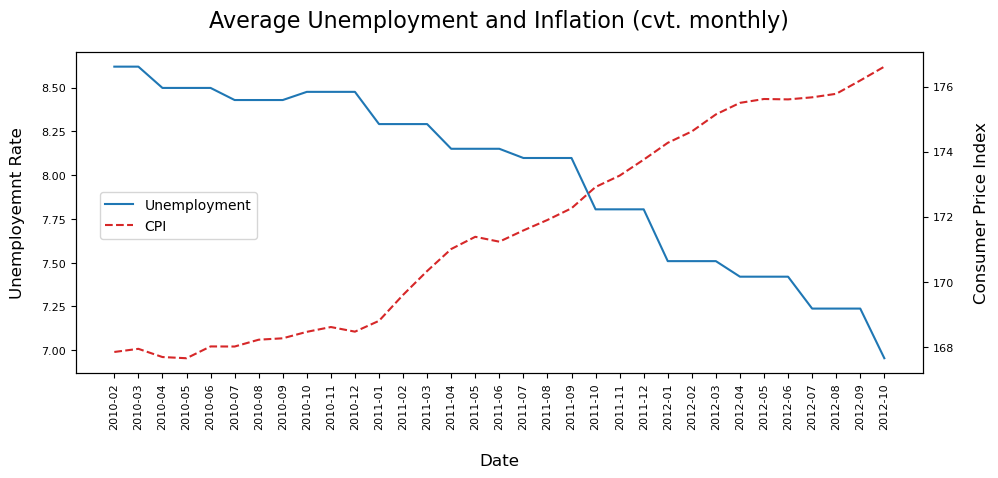

In [24]:
fig = plt.figure(figsize=(10, 5))
ax  = plt.subplot(111)

c1 = 'tab:blue'
ax.plot(df.year_month.unique(),
         df[df['Dept'] == 1].groupby(['year_month'])['Unemployment'].mean(),
         color = c1,
        label  = 'Unemployment'
         )


plt.suptitle('Average Unemployment and Inflation (cvt. monthly)', fontsize=16)

plt.xticks(rotation = 90)
ax.xaxis.set_label_coords(0.5, -0.25)
ax.set_xlabel('Date', fontsize = 12)

ax.yaxis.set_label_coords(-0.06,0.5)
ax.set_ylabel('Unemployemnt Rate', fontsize=12)
ax.tick_params(axis = 'y', labelsize = 8)
ax.tick_params(axis = 'x', labelsize = 8)


ax2 = ax.twinx()
c2  = 'tab:red'
ax2.yaxis.set_label_coords(1.06,0.5)
ax2.set_ylabel('Consumer Price Index', fontsize=12) 

ax2.plot(df.year_month.unique(),
         df[df['Dept'] == 1].groupby(['year_month'])['CPI'].mean(),
         color    = c2,
        linestyle = 'dashed',
        label     = 'CPI')

ax2.tick_params(axis = 'y', labelsize = 8)

fig.legend(loc= (0.1,0.5) )
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [7]:
list_var = ['Store', 'year_quarter', 'Unemployment']

df2 = df[df['Dept'] == 1].groupby(['Store', 'year_quarter'])[list_var].agg({'Unemployment':'mean', 'year_quarter':'first'})

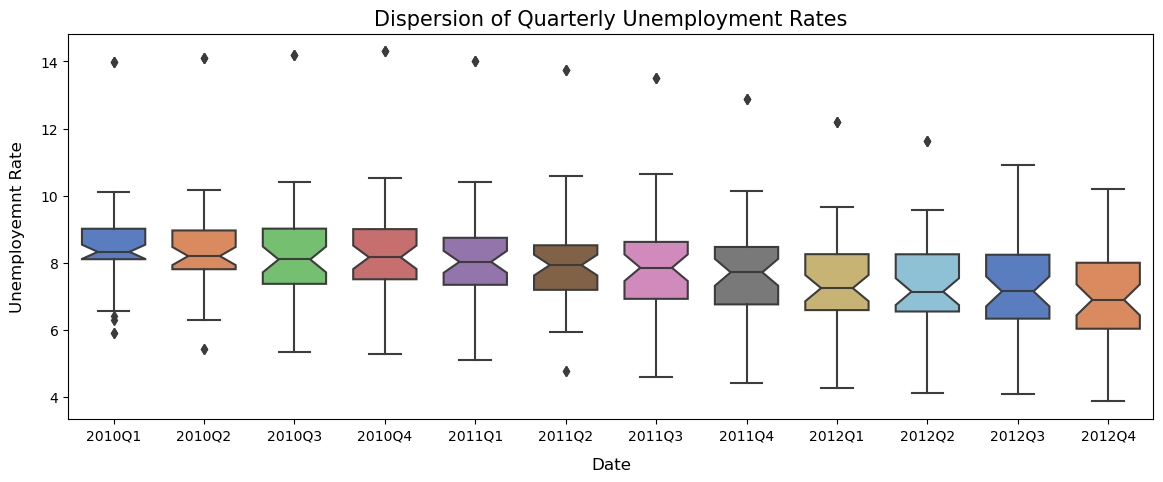

In [27]:
plt.figure(figsize=(14, 5))
g = sns.boxplot(df2,
            x       = 'year_quarter',
            y       = 'Unemployment',
            notch   = True,
            dodge   = True,   # separate boxes of different colors
            width   = 0.7,    # width of boxes
            whis    = 1.75,    # length of whiskers of a box
            palette = "muted"
       )

plt.title("Dispersion of Quarterly Unemployment Rates", fontsize = 15)
g.xaxis.set_label_coords(0.5, -0.1)
g.set_xlabel('Date', fontsize=12)

g.yaxis.set_label_coords(-0.04,0.5)
g.set_ylabel('Unemployemnt Rate', fontsize=12)

plt.show()

In [8]:
# CPI distribution
list_var = ['Store', 'year_quarter', 'CPI']

df2 = df[df['Dept'] == 1].groupby(['Store', 'year_quarter'])[list_var].agg({'CPI':'mean', 'year_quarter':'first'})

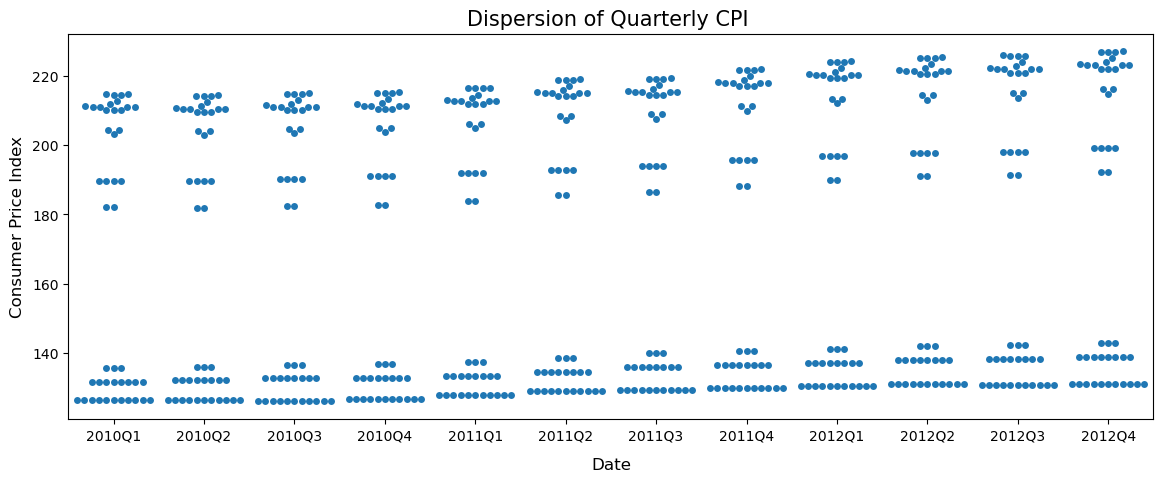

In [29]:
plt.figure(figsize=(14, 5))

g = sns.swarmplot(df2,
            x       = 'year_quarter',
            y       = 'CPI',
            dodge   = True
       )

plt.title("Dispersion of Quarterly CPI ", fontsize = 15)
g.xaxis.set_label_coords(0.5, -0.1)
g.set_xlabel('Date', fontsize=12)

g.yaxis.set_label_coords(-0.04,0.5)
g.set_ylabel('Consumer Price Index', fontsize=12)

plt.show()

In [9]:
list_var = ['Store', 'year_quarter', 'Fuel_Price']
df2 = df[df['Dept'] == 1].groupby(['Store', 'Fuel_Price'])[list_var].agg({'Fuel_Price':'mean', 'year_quarter':'first'})

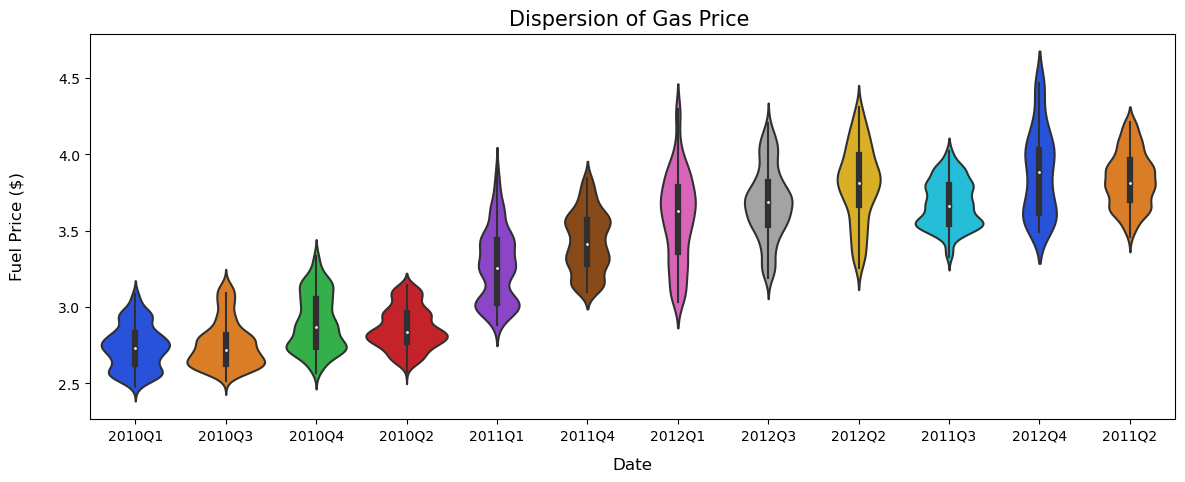

In [31]:
plt.figure(figsize=(14, 5))

g = sns.violinplot(df2,
            x       = 'year_quarter',
            y       = 'Fuel_Price',
              width = 0.9,
              dodge = True,
         saturation = 0.70,
            palette = "bright",
       )


plt.title("Dispersion of Gas Price ", fontsize = 15)
g.xaxis.set_label_coords(0.5, -0.1)
g.set_xlabel('Date', fontsize=12)

g.yaxis.set_label_coords(-0.06,0.5)
g.set_ylabel('Fuel Price (\$)', fontsize=12)

plt.show()

Similar to the CPI, a significant amount of dispersion exists in fuel price levels. 

### Store Characteristics <a id="1.2.2"></a>


As mentioned earlier, this dataset reports sales for three different types of stores. This actegorization seems to be based on the size of the store. In this section, I want to better understand this variable. 



In [6]:
[s1, s2] = np.unique(df.groupby(['Store', 'Type']).agg({'Type':'first'}),
                               return_counts=True)

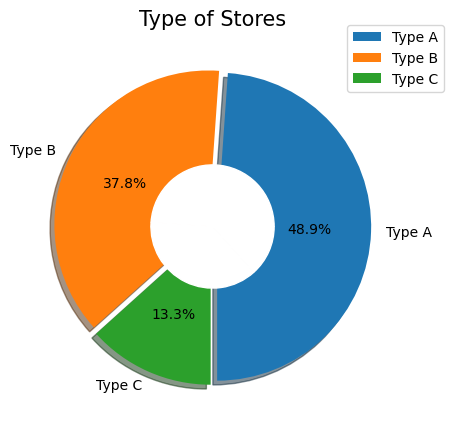

In [33]:
plt.figure(figsize=(5, 5))

plt.pie(s2,
            labels = ['Type A', 'Type B', 'Type C'],
        startangle = -90,
            shadow = True, 
           explode = (0.03, 0.03, 0.03),
           autopct ='%1.1f%%'
       )

plt.pie(s2, radius=0.4, colors='w',
       wedgeprops=dict(width=0.4, edgecolor='w'))


plt.legend(loc= (0.85,0.85))
plt.title("Type of Stores", fontsize = 15)

plt.show()



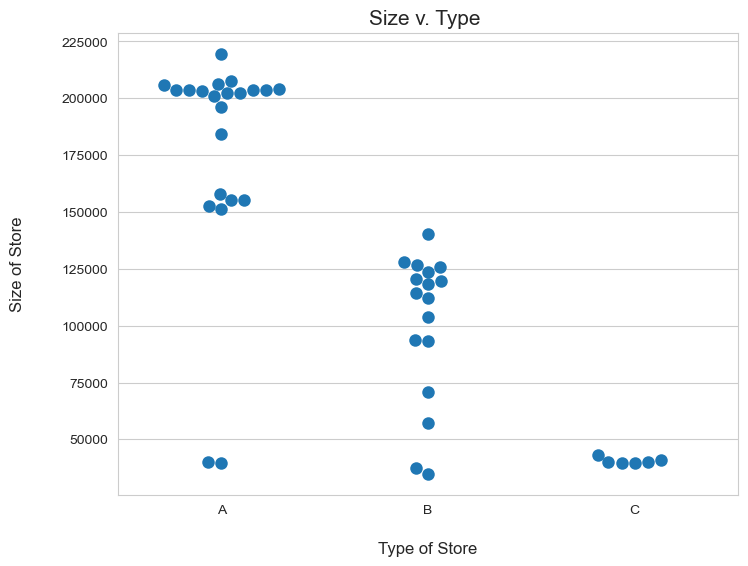

In [34]:
sns.set_style("whitegrid")
plt.figure(figsize=(8, 6))

g = sns.swarmplot(df,
            x       = df.groupby(['Store', 'Size', 'Type']).agg({'Type':'first'})['Type'],
            y       = df.groupby(['Store', 'Size', 'Type']).agg({'Size':'first'})['Size'], 
            dodge   = True,
               size = 9,
          edgecolor = 'tab:blue'
       )

plt.title("Size v. Type ", fontsize = 15)
g.xaxis.set_label_coords(0.5, -0.1)
g.set_xlabel('Type of Store', fontsize=12)

g.yaxis.set_label_coords(-0.15,0.5)
g.set_ylabel('Size of Store', fontsize=12)

plt.show()

Based on the above graph, it is evident that the store's type is mostly indicative of its size. However, this correlation is not perfect. The figure above clearly shows that while the size of all type `C` stores is under `50000`, there are some type `A` and `B` stores under this threshold as well. I don't know what this `Size` variable captures but I guess it has to do with the number of items that are available in the store.  

#### Aggregated Sales
In this section, I compute store-wide sales -*i.e.*, aggregated across all departments- and plot them over time. Also, I am trying to find out if there is a correlation between `type`, `sale`, and `IsHoliday`.

In [7]:
df['Store_Sale'] = df.groupby(['Store', 'Date'])['Weekly_Sales'].transform('sum')

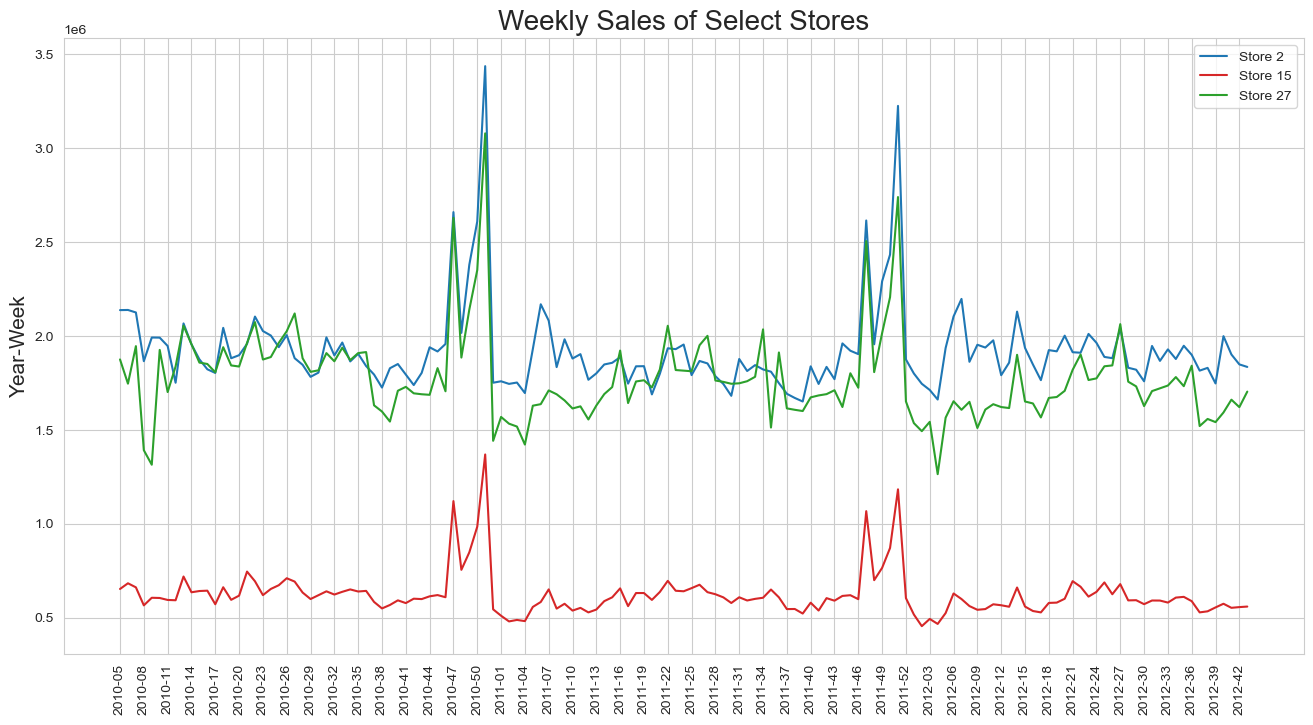

In [58]:
fig = plt.figure(figsize=(16, 8))


plt.title("Weekly Sales of Select Stores", fontsize = 20)
plt.ylabel("Weekly Sales", fontsize = 15)
plt.ylabel("Year-Week", fontsize = 15)

plt.plot(df.year_week.unique(),
         df[df['Store'] == 2].groupby(['year_week'])['Store_Sale'].mean(),
         color    = 'tab:blue',
         label    = 'Store 2')

plt.plot(df.year_week.unique(),
         df[df['Store'] == 15].groupby(['year_week'])['Store_Sale'].mean(),
         color    = 'tab:red',
         label    = 'Store 15')

plt.plot(df.year_week.unique(),
         df[df['Store'] == 27].groupby(['year_week'])['Store_Sale'].mean(),
         color    = 'tab:green',
         label    = 'Store 27')

plt.xticks(rotation = 90)
plt.xticks(df.year_week.unique()[::3])
plt.legend()
plt.show()


This figure shows a high correlation between sales during the year. This is indicative of a strong holiday effect in the data; specially around the Thanksgiving and the Christmas. In the foloowing figure, I will study the holiday weeks.

### Holidays <a id="1.2.3"></a>


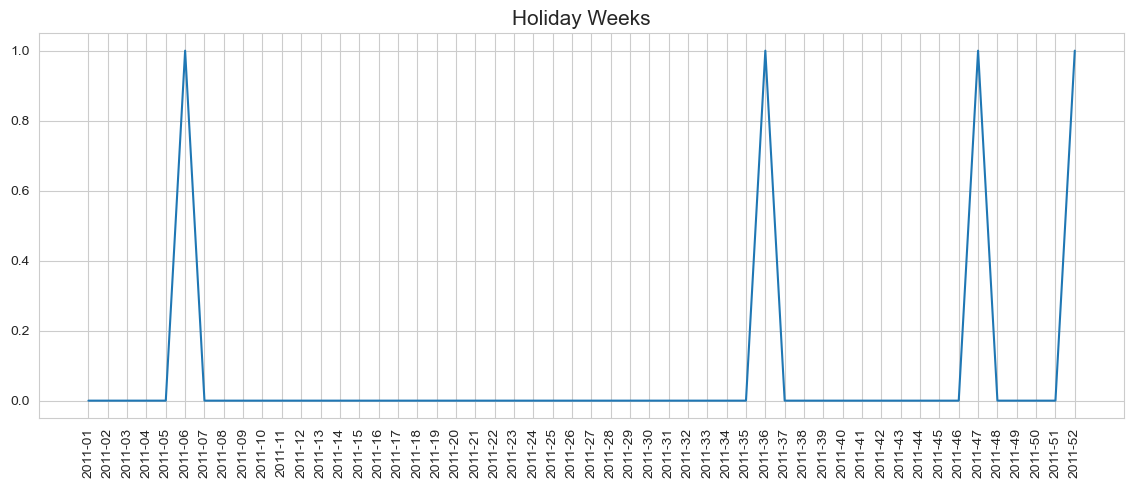

In [98]:
sns.set_style("whitegrid")

fig = plt.figure(figsize=(14, 5))
ax  = plt.subplot(111)

plt.title("Holiday Weeks", fontsize = 15)

plt.plot(df[(df['Year'] == 2011) & (df['Store'] == 1)  & (df['Dept'] == 1)]['year_week'],
         df[(df['Year'] == 2011) & (df['Store'] == 1)  & (df['Dept'] == 1)]['IsHoliday']
         )


plt.xticks(rotation = 90)

plt.show()

There are **four** holiday weeks in the year:
1. Week 6: Super Bowl Week
2. Week 36: Labor Day
3. Week 47: Thanksgiving
4. Week 52: Christmas and New Year

To analayze if these holidays have any impact on weekly sales, I plot the aggreagte weekly sales of some stores on the above plot to see if there is any correlation between the two.  

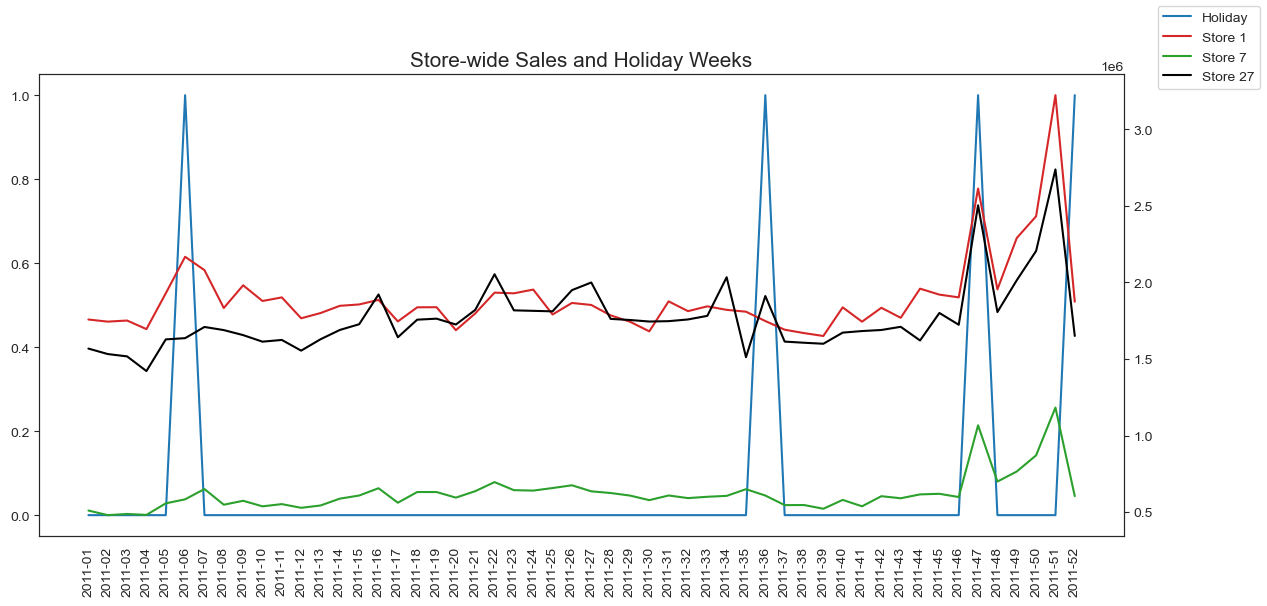

In [101]:
sns.set_style("white")
fig = plt.figure(figsize=(14, 6))
ax  = plt.subplot(111)

plt.xticks(rotation = 90)
plt.title("Store-wide Sales and Holiday Weeks", fontsize = 15)

ax.plot(df[(df['Year'] == 2011) & (df['Store'] == 1)  & (df['Dept'] == 1)]['year_week'],
         df[(df['Year'] == 2011) & (df['Store'] == 1)  & (df['Dept'] == 1)]['IsHoliday'], label = "Holiday")

ax2 = ax.twinx()

ax2.plot(df[(df['Year'] == 2011) & (df['Store'] == 1)  & (df['Dept'] == 1)]['year_week'],
         df[(df['Year'] == 2011) & (df['Store'] == 2)].groupby(['year_week'])['Store_Sale'].mean(),
         color    = 'tab:red', label = "Store 1")

ax2.plot(df[(df['Year'] == 2011) & (df['Store'] == 1)  & (df['Dept'] == 1)]['year_week'],
         df[(df['Year'] == 2011) & (df['Store'] == 15)].groupby(['year_week'])['Store_Sale'].mean(),
         color    = 'tab:green', label = "Store 7")

ax2.plot(df[(df['Year'] == 2011) & (df['Store'] == 1)  & (df['Dept'] == 1)]['year_week'],
         df[(df['Year'] == 2011) & (df['Store'] == 27)].groupby(['year_week'])['Store_Sale'].mean(),
         color    = 'black', label = "Store 27")


fig.legend()
plt.show()

It seems that the only sustained correlation between `IsHoliday` and weekly `Sales` is during the holiday season. For that reason, I create four new dummy variable that each take the value of `1` in weeks *47*, *49*, *50*, and *51*. This seems to be a more appropriate predictor of a `deterministic` rise in weekly sales. I will check the correlations later to verify.

It is possible that different department are impacted differently by the holidays. To better understand this, I plot weekly sales of various departments of the first store in 2011. As is evident, some departments experience large holiday effects while this impact for others is alomst negligible -or, even in the opposite direction.

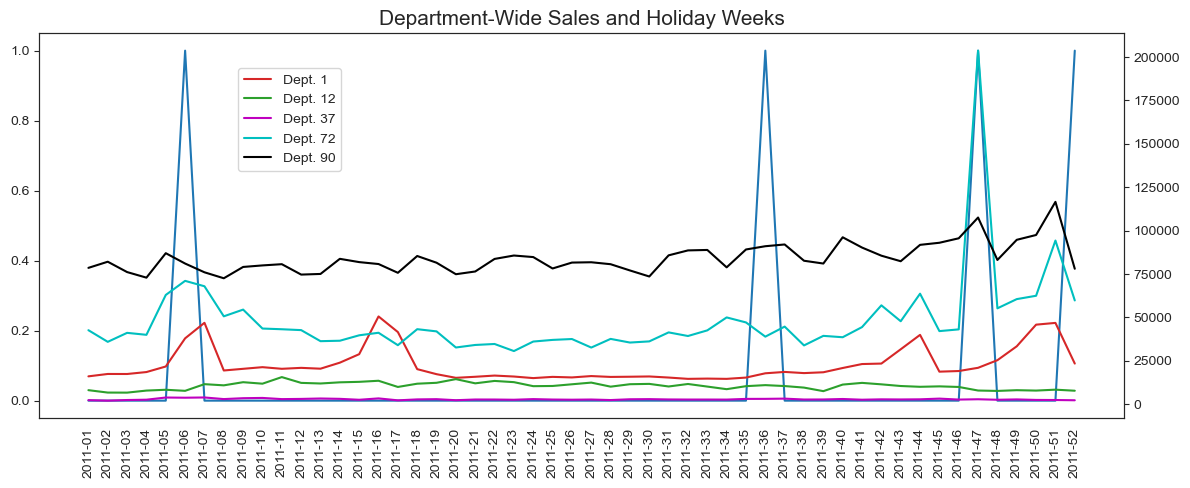

In [63]:
fig = plt.figure(figsize=(14, 5))
ax  = plt.subplot(111)

plt.xticks(rotation = 90)
plt.title("Department-Wide Sales and Holiday Weeks", fontsize = 15)

plt.plot(df[(df['Year'] == 2011) & (df['Store'] == 1)  & (df['Dept'] == 1)]['year_week'],
         df[(df['Year'] == 2011) & (df['Store'] == 1)  & (df['Dept'] == 1)]['IsHoliday']
         )


ax2 = ax.twinx()

ax2.plot(df[(df['Year'] == 2011) & (df['Store'] == 1)  & (df['Dept'] == 1)]['year_week'],
         df[(df['Year'] == 2011) & (df['Store'] == 1)  & (df['Dept'] == 1)]['Weekly_Sales'],
         color    = 'tab:red',
        label     = 'Dept. 1')

ax2.plot(df[(df['Year'] == 2011) & (df['Store'] == 1)  & (df['Dept'] == 1)]['year_week'],
         df[(df['Year'] == 2011) & (df['Store'] == 1)  & (df['Dept'] == 12)]['Weekly_Sales'],
         color    = 'tab:green',
        label     = 'Dept. 12')

ax2.plot(df[(df['Year'] == 2011) & (df['Store'] == 1)  & (df['Dept'] == 1)]['year_week'],
         df[(df['Year'] == 2011) & (df['Store'] == 1)  & (df['Dept'] == 37)]['Weekly_Sales'],
         color    = 'm',
        label     = 'Dept. 37')

ax2.plot(df[(df['Year'] == 2011) & (df['Store'] == 1)  & (df['Dept'] == 1)]['year_week'],
         df[(df['Year'] == 2011) & (df['Store'] == 1)  & (df['Dept'] == 72)]['Weekly_Sales'],
         color    = 'c',
        label     = 'Dept. 72')


ax2.plot(df[(df['Year'] == 2011) & (df['Store'] == 1)  & (df['Dept'] == 1)]['year_week'],
         df[(df['Year'] == 2011) & (df['Store'] == 1)  & (df['Dept'] == 90)]['Weekly_Sales'],
         color    = 'black',
        label     = 'Dept. 90')

fig.legend(loc= (0.2,0.65))
plt.show()

In [70]:
# let's start by creating dummies for Type. Creating dummies is straightforward. 
# df = pd.get_dummies(df, columns = ['Type'])

# may also create dummies with `pd.get_dummies()`, and then either `merge` or `concat`

# But, I want to design my own dummies. So, I directly define them. 

df.loc[df["Week"] != 47, "week47"] = 0
df.loc[df["Week"] == 47, "week47"] = 1

df.loc[df["Week"] != 49, "week49"] = 0
df.loc[df["Week"] == 49, "week49"] = 1

df.loc[df["Week"] != 50, "week50"] = 0
df.loc[df["Week"] == 50, "week50"] = 1

df.loc[df["Week"] != 51, "week51"] = 0
df.loc[df["Week"] == 51, "week51"] = 1

# To verify:
# df['week47'].describe()
# df.groupby("week47")["week47"].count()

### Relations and Corelations <a id="1.3"></a>
In this section, I examine the relationship between all variables in the dataframe. Particulary, I wnat to understand how economics factors, store characteristics, and holiday weeks influence store sales. 


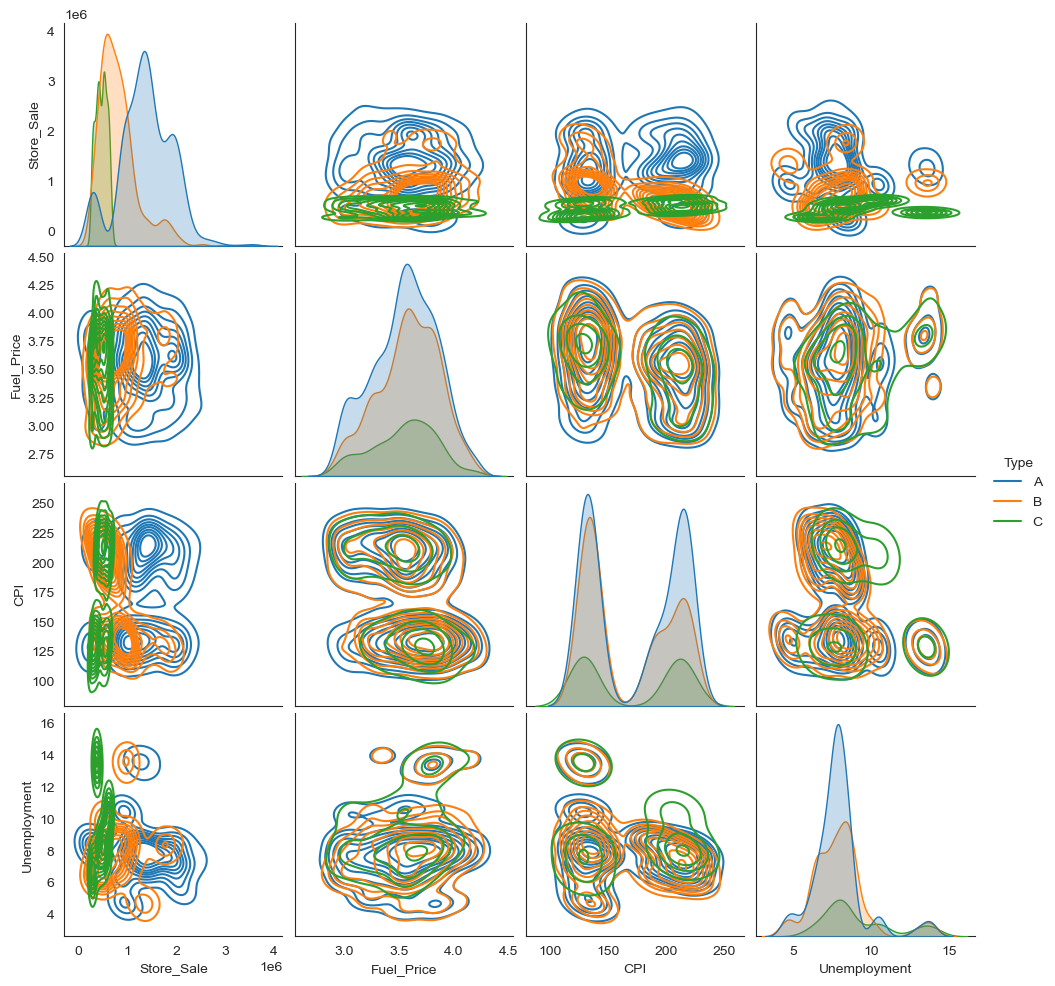

In [65]:
df2 = df[(df['Year'] == 2011) & (df['Dept'] == 1)]
var_list = ['Store_Sale', 'Fuel_Price', 'CPI', 'Unemployment', 'Type']
df_now = df2[var_list]


sns.pairplot(df_now,
              kind = "kde",
         diag_kind = 'kde',
              hue  = "Type", 
            corner = False)


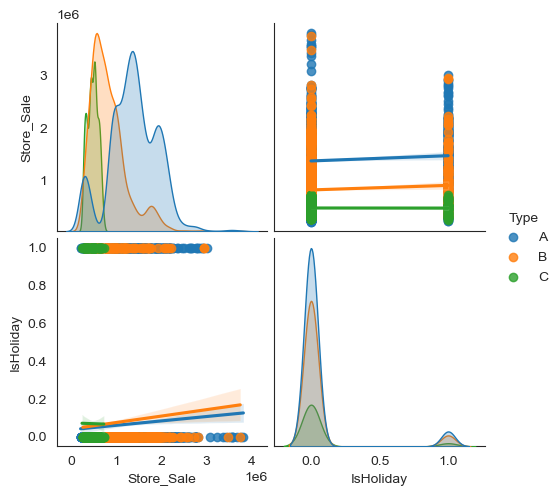

In [66]:
df2 = df[(df['Dept'] == 1)]
var_list = ['Store_Sale', 'Fuel_Price', 'CPI', 'Unemployment', 'IsHoliday' , 'Type']
df_now = df2[var_list]



xvar_list = ['Store_Sale', 'IsHoliday']
yvar_list = ['Store_Sale', 'IsHoliday']

sns.pairplot(df_now ,
            x_vars = xvar_list,
            y_vars = yvar_list,
              kind = "reg",
               hue = 'Type',
         diag_kind = 'kde')

[]

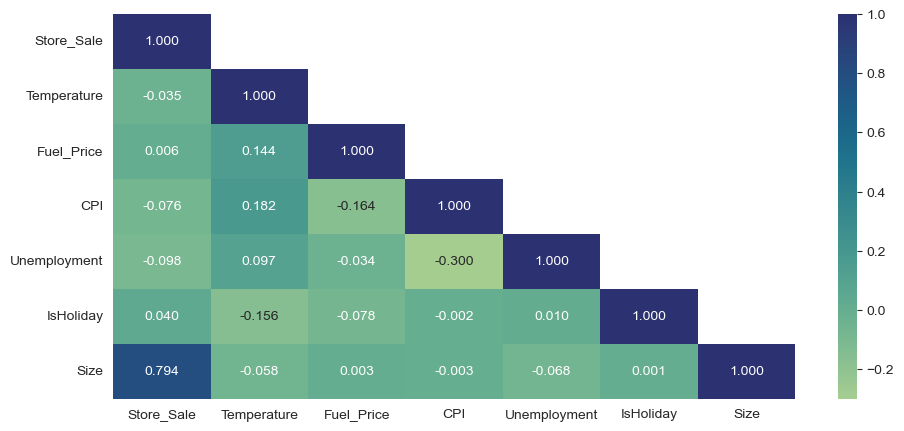

In [82]:
var_list = ['Store_Sale', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'IsHoliday', 'Size']
df_now = df[var_list]

corr = df_now.corr()
plt.figure(figsize=(11, 5))

sns.heatmap(corr,
            annot = True,
              fmt = ".3f",
             cmap = 'crest',
            mask = np.triu(np.ones_like(corr), k=1)
           )
plt.plot()

This concludes the data exploration section of this notebook. In the next section, which forecasts sales data, I will forecast weekly sales at `store-level` for a representative store. 

## Part II: Forecasting <a id="2"></a>

- [Data Preparation](#2.1) 
- [Diagnostic Plots and Trend Analysis](#2.2)
    * [QQ, ACF, PACF Plots](#2.2.1)
    * [Seasonal Decompisiton and Unit Root Tests](#2.2.2)
  
   
- [Forecasting Models](#2.3)
    * [White Noise](#2.3.1)
    * [Random Walk](#2.3.2)
    * [Weighted and Rolling Averages](#2.3.3)
    * [Exponential Smoothing](#2.3.4)
    * [Time Series Models](#2.3.1)
    
- [Comparing Forecasts](#2.4)
    * [Accuracy Measures](#2.4.1)
    * [Visual Comparison](#2.4.2)
- [Concluding Remarks](#2.5)

In [94]:
dff = df[(df['Store'] == 1) & (df['Dept'] == 1)].copy()
dff = dff.drop(['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'Weekly_Sales', 
                                                                 'Store', 'Dept', 'Type', 'Size'], axis=1).copy()

## Data Preparation <a id="2.1"></a>
I set the `Date` variable as the `index` of the dataframe and make sure that there are no frequency mismatches. Eventually, this leaves us with 143 weekly observations.


In [95]:
dff.loc[0,'Date'].day_name()

'Friday'

In [96]:
# new index
dff.set_index("Date", inplace = True)

This, as seen below, set the `Date` variable as the index of the series. This will be useful when we model the sale series. 

In [97]:
dff.head()

Temperature  Fuel_Price         CPI  Unemployment  IsHoliday  \
Date                                                                       
2010-02-05        42.31       2.572  211.096358         8.106      False   
2010-02-12        38.51       2.548  211.242170         8.106       True   
2010-02-19        39.93       2.514  211.289143         8.106      False   
2010-02-26        46.63       2.561  211.319643         8.106      False   
2010-03-05        46.50       2.625  211.350143         8.106      False   

            Year  Quarter  Month  Week year_quarter year_month year_week  \
Date                                                                       
2010-02-05  2010        1      2     5       2010Q1    2010-02   2010-05   
2010-02-12  2010        1      2     6       2010Q1    2010-02   2010-06   
2010-02-19  2010        1      2     7       2010Q1    2010-02   2010-07   
2010-02-26  2010        1      2     8       2010Q1    2010-02   2010-08   
2010-03-05  2010        1      3     9       2010Q1    2010-03   2010-09   

            Store_Sale  week47  week49  week50  week51  
Date                                                    
2010-02-05  1643690.90     0.0     0.0     0.0     0.0  
2010-02-12  1641957.44     0.0     0.0     0.0     0.0  
2010-02-19  1611968.17     0.0     0.0     0.0     0.0  
2010-02-26  1409727.59     0.0     0.0     0.0     0.0  
2010-03-05  1554806.68     0.0     0.0     0.0     0.0

In order to declare the `frequency` of the data,  I use the `asfreq()` method.   

Calling the `index.freq` method shows that our data is a `weekly` series. However, This sets all the dates on `Sunday` while our data is stored for `Friday` of each week. In other words, as soon as we declare a frequency, the dataframe turns into an empty one! 

To fix this problem, we should inform `Python` that our weeks must be recored on Fridays.

In [98]:
dff = dff.asfreq('W-FRI')
dff.index.freq

<Week: weekday=4>

In [20]:
dff.head()

Temperature  Fuel_Price         CPI  Unemployment  IsHoliday  \
Date                                                                       
2010-02-05        42.31       2.572  211.096358         8.106      False   
2010-02-12        38.51       2.548  211.242170         8.106       True   
2010-02-19        39.93       2.514  211.289143         8.106      False   
2010-02-26        46.63       2.561  211.319643         8.106      False   
2010-03-05        46.50       2.625  211.350143         8.106      False   

            Year  Quarter  Month  Week year_quarter year_month year_week  \
Date                                                                       
2010-02-05  2010        1      2     5       2010Q1    2010-02   2010-05   
2010-02-12  2010        1      2     6       2010Q1    2010-02   2010-06   
2010-02-19  2010        1      2     7       2010Q1    2010-02   2010-07   
2010-02-26  2010        1      2     8       2010Q1    2010-02   2010-08   
2010-03-05  2010        1      3     9       2010Q1    2010-03   2010-09   

            Store_Sale  week47  week49  week50  week51  
Date                                                    
2010-02-05  1643690.90     0.0     0.0     0.0     0.0  
2010-02-12  1641957.44     0.0     0.0     0.0     0.0  
2010-02-19  1611968.17     0.0     0.0     0.0     0.0  
2010-02-26  1409727.59     0.0     0.0     0.0     0.0  
2010-03-05  1554806.68     0.0     0.0     0.0     0.0

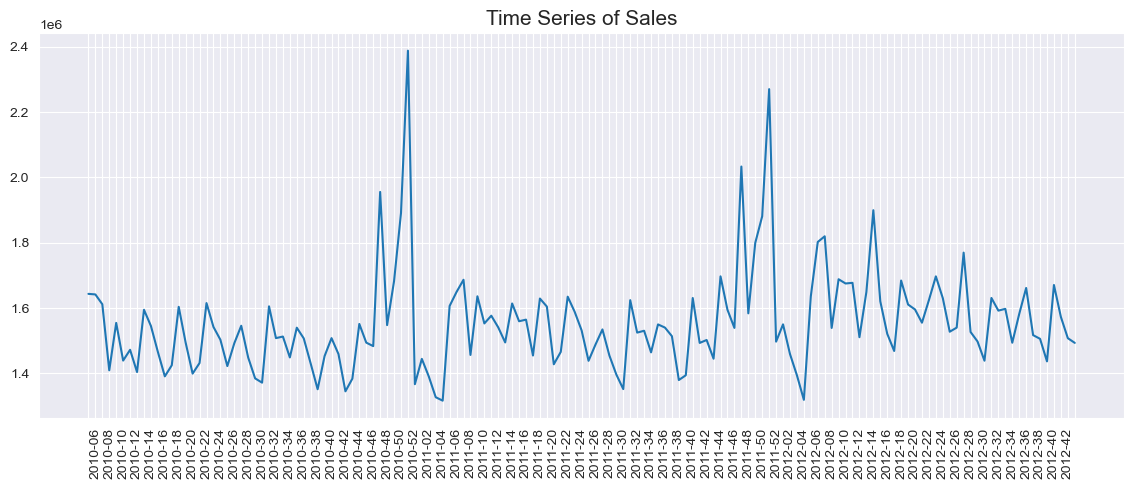

In [155]:
sns.set_style("darkgrid")

fig = plt.figure(figsize=(14, 5))
ax  = plt.subplot(111)

plt.xticks(rotation = 90)
plt.title("Time Series of Sales", fontsize = 15)

plt.plot(dff['year_week'],
         dff['Store_Sale']
         )

plt.setp(ax.get_xticklabels()[::2], visible=False)

plt.show()

## Diagnostic Plots and Trend Analysis <a id="2.2"></a>
The main goal of this subsection is to better understand the statistical properties of the weekly sale series. I start by basic plots about normality and autocorrelations. Then, I look at stationary tests that deteremine whether standard time series models are applicable. 

### Quantile-Quantile (QQ), ACF, PACF Plots <a id="2.2.1"></a>




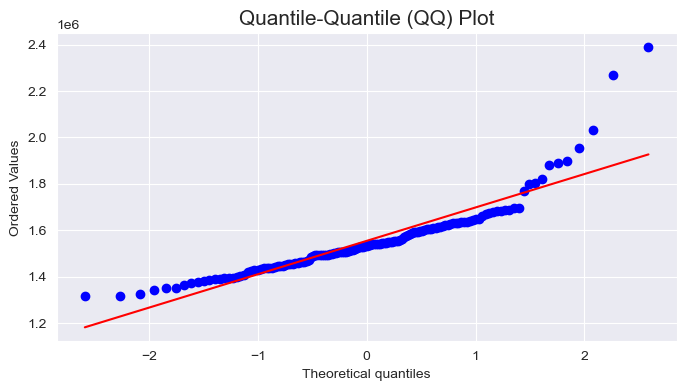

In [22]:
sns.set_style("darkgrid")

stats.probplot(dff.Store_Sale, plot = pylab)
pylab.title("Quantile-Quantile (QQ) Plot", fontsize = 15)
pylab.show()

This confirms that the sale series is NOT `normally distributed`. This is primarily due to unusally high sales week, which mostly belong to holidays. This is something to remember when forecasting the series. 



For ACFs, I go up to 55 lags/weeks. This is to make sure that there is an annual component to the data. Otherwise, as the graph below shows, only the first and the foruth lag appear to be statisticsally significant. However, including a yearly time ternd in the regression -that connects a week to its counterpart in pervious years- must be considered.



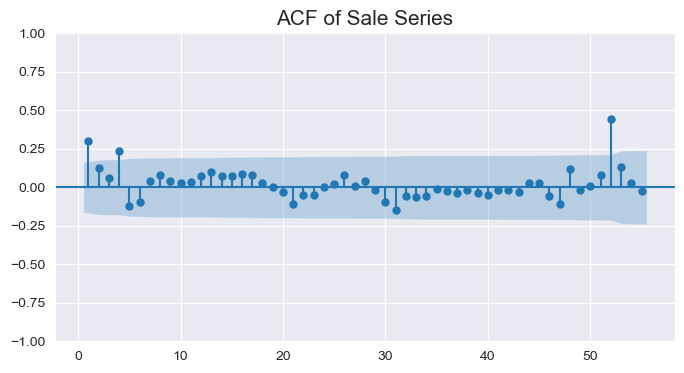

In [23]:
pylab.rcParams['figure.figsize'] = (8, 4)
sgt.plot_acf(dff.Store_Sale, lags = 55, zero = False)
plt.title("ACF of Sale Series", size = 15)
plt.show()

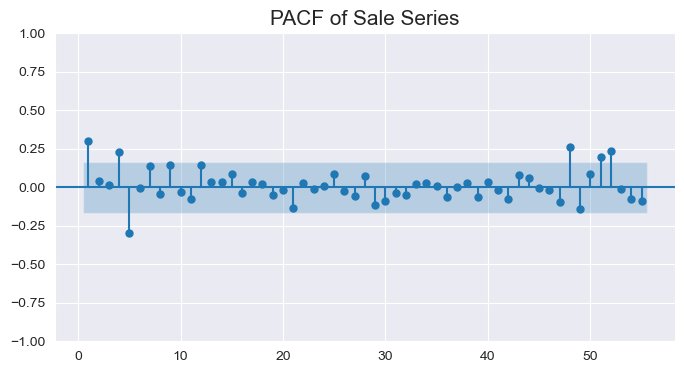

In [24]:
pylab.rcParams['figure.figsize'] = (8, 4)
sgt.plot_pacf(dff.Store_Sale, lags = 55, zero = False, method='ywm')
plt.title("PACF of Sale Series", size = 15)
plt.show()

### Seasonal Decompisiton and Unit Root Tests <a id="2.2.2"></a>

We already know that there are seasonal patterns in the data. I start by plotting the sales series against the temperature. Daily temperatures clearly have a seasonal pattern that is followed over the years. However, when the sale series is plotted against the temperature, there does not appear to be a seasonality in the sales data that correlates with the temperature. This is while the correlation coefficient between the two series is `-0.22`.

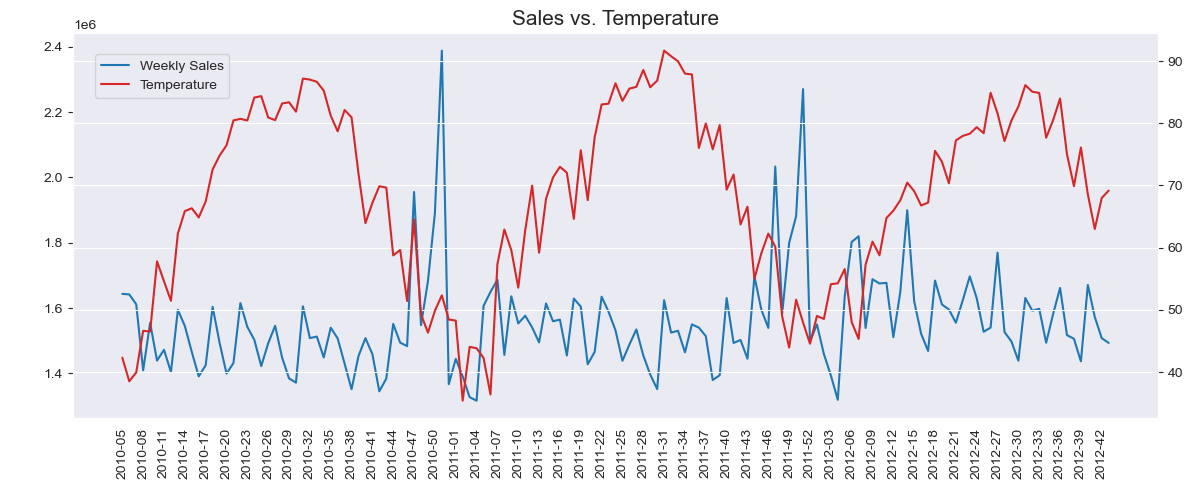

In [164]:
fig = plt.figure(figsize=(14, 5))
ax  = plt.subplot(111)
ax.grid(False)
plt.xticks(rotation = 90)
plt.title("Sales vs. Temperature", fontsize = 15)

ax.plot(dff['year_week'],
         dff['Store_Sale'],
         color = 'tab:blue',
         label = 'Weekly Sales'
         )



ax2 = ax.twinx()
ax2.plot(dff['year_week'],
        dff['Temperature'],
         color = 'tab:red',
         label = 'Temperature'
         )

plt.xticks(df.year_week.unique()[::3])
fig.legend(loc = (0.08, 0.8))
plt.show()

I use Python's `seasonal_decompose()` method to decompose the sale series to three different sereis:
1. Trend
2. Seasonal
3. Residual

It is worth mentioning that we should be careful when we decompose a `weekly` data series. I am looking for `Monthly` trends in the data. Therefore, I am going to use `period = 4` in my decomposition.

Since there doesn't seem to be an increase in the amplitude of the signal over time, I am going to use an additive decomposition approach. This model assumes that  

<h4><center>$x(t) = Trend(t) + Seasonal(t) + Residual(t)$</center></h4>

In [166]:
sale_dc_add = seasonal_decompose(dff.Store_Sale, model = "additive", period = 4)

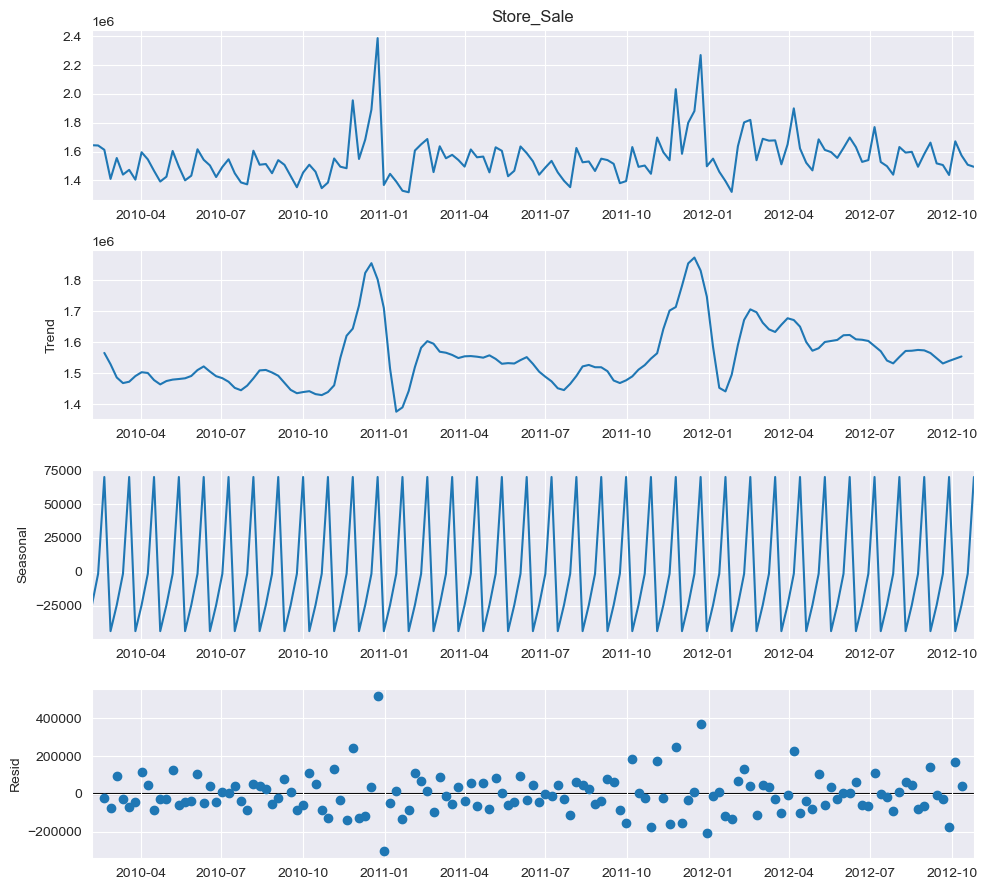

In [168]:
pylab.rcParams['figure.figsize'] = (10, 9)
sale_dc_add.plot()
plt.show()

There seems to be a clear repetitive `monthly` component, which can be used for prediction. 


**How Does Decomposition Work?**


Traditionally, we used to use regressions on trend -dummy- variables for the long-run trends and `moving averages` for seasonal components. However, a more technical approach to computing each series is to use `local` regression methods such as the `LOESS` regression, which is an abbreviation for *locally estimated scatterplot smoothing*.  

This method zooms in on a subset of the data in a short time window. For instance in Python, the `period` variable is basically the number of observations in one window. Then, only focusing on that window, we find the predicted value of each observation in the window only based on other observations in the window. The only difference compared to a simple regression is that when we try to find the *smoothed* value for each observation, the observations that are closer to it will have a higher weight. In other words, this is a weighted regression of local observations. If we do the same for all observations in the small window, it gives a *smoothed* trajectory of the data based on information in that small time period. The rest of the fluctuations can be attributed to information that belong to other horizons/frequncies.   

This window is then rolled over throughout the sample to provide the decomposed series. Obviously, if we expand the time window, the frequency of information incorporated in each window falls and, therefore, more fluctuations are absorbed. Hypothetically, if we include all the information, the result would be equal to a linear regression model, which is not so smooth! 

I cannot not cite this brillinat and very short video from Aric LaBarr ([Link](https://www.youtube.com/watch?v=0ar9extHObg)).

**What Do We Do with Decomposed Series?**
Trends and seasonal components are, by structure, easier to forecast. We can use standard `ARMA` models or even standard ploynomials to forecast them. The residual series, which is more noisy, is the most difficult to deal with. Dealing with the noise seris is the challange. In this exercise, I do not work with the decomposed series. This is because I don't want to add three forecasting errors to my model. Specially, the long-run tren does not seem so deterministic. With a rather limited number of observations, I am going to work with the original series. 

**Stationarity**

In [25]:
def adf_res(series):
    pval = sts.adfuller(series)[1]

    if pval <= 0.01:
        print('The Series is Stationariy with P-Value = ', pval.round(5))
    else:
        print('The Series is NOT Stationariy with P-Value = ', pval.round(5))

In [26]:
adf_res(dff.Store_Sale)

The Series is Stationariy with P-Value =  1e-05


The results of an `Augmented Dickey-Fuller` test reveal that our sale series *is* stationary. This is because the `P-value` of the test is very small, which allows us to reject the null hypothesis -i.e., the series has a unit root- with great confidence. This paves the way for estimating an `ARMA` model.  

In addition to that, this test indicates an autocorrelation between the observations up to the **order 4**.

In [27]:
# seasonally adjusted difference
s_diff = dff['Store_Sale'] - dff['Store_Sale'].shift(4)

adf_res(s_diff.dropna())

The Series is Stationariy with P-Value =  0.0


Both tests strongly suggest that the sale series is stationary. 

## Forecasting Models <a id="2.3"></a>
In this section I am using various models to forecast the sale series. I start with some of the basic building blocks of the time series. 

### White Noise <a id="2.3.1"></a>
White Noise is a random process whose samples are regarded as a sequence of serially uncorrelated random variables with zero mean and finite variance. As the name suggests, white noise does not contain any valuable information. Therefore, it would be impossible to forecast a series that is a white noise. I construct a white noise with the mean and standard deviation of the sale series. 

In [12]:
wn = np.random.normal(loc = dff.Store_Sale.mean(), scale = dff.Store_Sale.std(), size = len(dff))

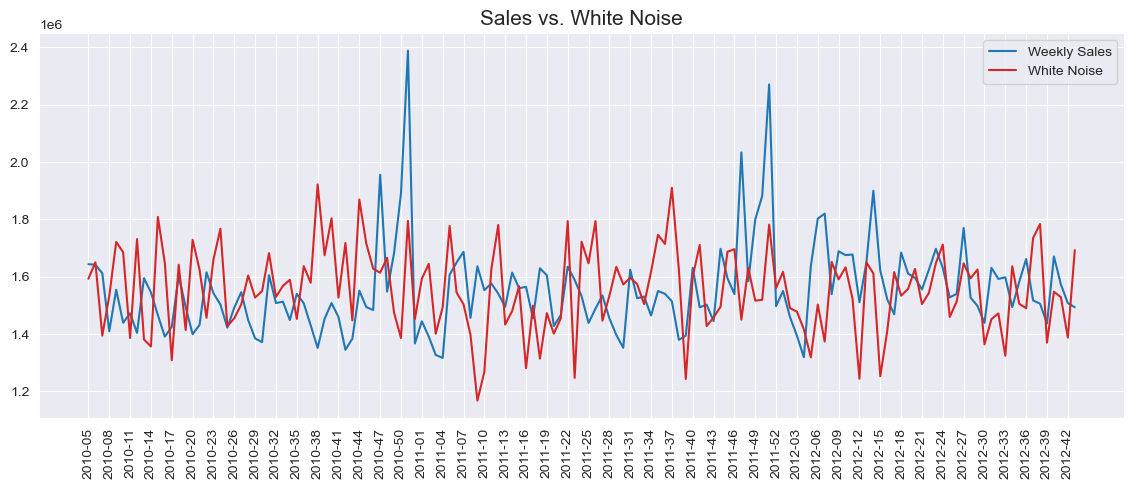

In [190]:
sns.set_style("darkgrid")

fig = plt.figure(figsize=(14, 5))
ax  = plt.subplot(111)

plt.xticks(rotation = 90)
plt.title("Sales vs. White Noise", fontsize = 15)

plt.plot(dff['year_week'],
         dff['Store_Sale'],
         color = 'tab:blue',
         label = 'Weekly Sales'
         )


plt.plot(dff['year_week'],
         wn,
         color = 'tab:red',
         label = 'White Noise'
         )

plt.legend()
plt.xticks(df.year_week.unique()[::3])

plt.show()

### Random Walk <a id="2.3.2"></a>
By definition, a random walk follows this pattern: $x_t = x_{t-1} + \epsilon_t$ where $\epsilon_t$ is a white noise. To compare with the sale series, I simulatae a random walk seriesthat starts from the mean of the sale series. Then, to simulates the `step`, I generate a random series from a `truncated` normal distribution so that its `mean`, `std`, `min` and `max` match the `first difference` of the sale  series.  



In [13]:
# define a truncated random normal 
from scipy.stats import truncnorm

def get_truncated_normal(mean, sd, low, upp):
    return truncnorm(
        (low - mean) / sd, (upp - mean) / sd, loc=mean, scale=sd)

# set the random variable function
RV = get_truncated_normal(mean = dff.Store_Sale.diff().mean(), sd = dff.Store_Sale.diff().std(),
                           low = dff.Store_Sale.diff().min(), upp = dff.Store_Sale.diff().max())

# generate the step series
np.random.seed(100)
eps = RV.rvs(len(dff))

In [14]:
# initiation of the random walk
rw    = np.zeros(len(dff))
rw[0] = dff.Store_Sale.mean()

# generate the randon walk series from the first observation
for i in range (1,len(dff)):
    rw[i] = rw[i-1] + eps[i]

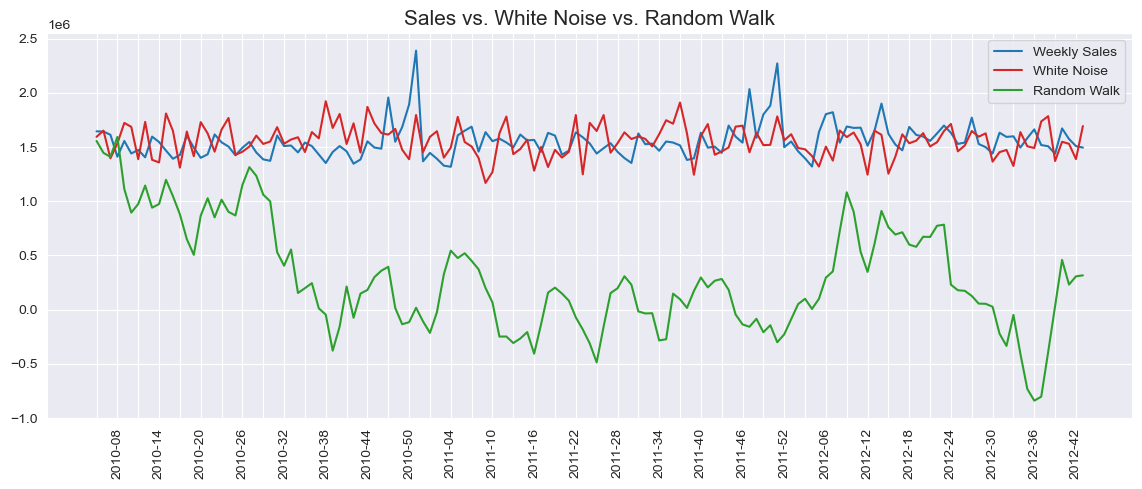

In [193]:
fig = plt.figure(figsize=(14, 5))
ax  = plt.subplot(111)

plt.xticks(rotation = 90)
plt.title("Sales vs. White Noise vs. Random Walk", fontsize = 15)

plt.plot(dff['year_week'],
         dff['Store_Sale'],
         color = 'tab:blue',
         label = 'Weekly Sales'
         )

plt.setp(ax.get_xticklabels()[::2], visible=False)

plt.plot(dff['year_week'],
         wn,
         color = 'tab:red',
         label = 'White Noise'
         )

plt.plot(dff['year_week'],
         rw,
         color = 'tab:green',
         label = 'Random Walk'
         )

plt.xticks(df.year_week.unique()[::3])

plt.legend()
plt.show()

### Weighted and Rolling Averages <a id="2.3.3"></a>

From this point onward, to validate various forecasting model, I spilit the data to a `train` and a `test` set. I am going to split the data in an `80-20` format. 

In [99]:
size = int(len(dff)*0.80)
# Data to be used in modeling and forecasting
dff_train = dff.iloc[:size].copy()
dff_test  = dff.iloc[size:].copy()

In [80]:
#Create an empty DataFrame to store all the forecasts
forecast = pd.DataFrame(index = dff_test.index)

forecast['Sales']         = dff_test.Store_Sale
forecast['White Noise']   = wn[-len(forecast):]
forecast['Naive']         = np.zeros(len(forecast)) # weekly sales in the last year

In [81]:
#  forecast: value of sales in the same week last year
for i in np.arange(0,len(forecast)):
    forecast.loc[forecast.index[i],'Naive'] = dff.loc[(dff['Year'] == forecast.index[i].year - 1) 
                                                      & (dff['Week'] == forecast.index[i].week), 'Store_Sale'].values[0]


**Seasonal Average Model**

I use an arithmetic average of three weeks -the same week, the one before, and the one after- of the last year to forecast the sales this year. If more data was available, a better approach would be to take the same average of sales in all previous years.

In [18]:
for i in np.arange(0,len(forecast)):
    ynow = forecast.index[i].year - 1
    wnow = forecast.index[i].week
    forecast.loc[forecast.index[i],'Seasonal_avg'] = dff.loc[(dff.Year == ynow) &
                                                                    (dff.Week.between(wnow-1, wnow+1))].Store_Sale.mean()
    

**Rolling Average Model**

This is basically a moving average forecast where we consider the last four observations. The choice of lags included is motivated by our earlier data exploration; specially the ACF and the PACF.





In [82]:
# the first argument gives the window size 
# the argument closed='left' to ensure that all lags are on the left

dff['rolling_avg'] = dff.Store_Sale.rolling(4, closed='left').mean()
for i in np.arange(0,len(forecast)):
    forecast.loc[forecast.index[i],'Rolling_avg'] = dff.loc[(dff['Year'] == forecast.index[i].year) 
                                                        & (dff['Week'] == forecast.index[i].week)].rolling_avg.values[0] 

    

**Weighted Rolling Average Model**

This is basically two-third of the last year value and one-third of the rolling average forecast. 


In [83]:
forecast['Weighted_R_avg'] = 2/3*forecast.Naive + 1/3*forecast.Rolling_avg

### Exponential Smoothing <a id="2.3.4"></a>

**1) Simple exponential smoothing**

A simple exponential smoothing is defined by :

$$
\hat{y}_{t} = \begin{cases}\alpha y_{t-1} + (1-\alpha) \hat{y}_{t-1} & \text{for} & t\leq n \\
                                               \alpha y_n + (1-\alpha) \hat{y}_n & \text{for} & t > n \end{cases} 
$$

where $\alpha \in [0,1]$ is a hyperparameter to be either selected or determined through an optimization algorithm.

This essentially implies that a simple exponential smoothing is a weighted sum of all previous values

$$
\hat{y}_{t+1} = \alpha \left[y_t +(1-\alpha) y_{t-1} + (1-\alpha)^2 y_{t-2} + \dots + (1-\alpha)^{t-1} y_1\right].
$$


**2) Double exponential smoothing**


To take care of trends, we can use double exponential smoothing, which is defined as 

$$
\hat{y}_{t} = \begin{cases} s_{t-1} + b_{t-1} & \text{for} & 1<t\leq n \\
                                                s_n + (t-n)b_{n}& \text{for} & t > n \end{cases}
$$

where 

$$
s_{t+1} = \alpha y_t + (1-\alpha) (s_{t-1} + b_{t-1}), \ s_1 = y_1, 
$$

$$
b_{t+1} = \beta (s_t - s_{t-1}) + (1-\beta) b_{t-1}, \ b_1 = y_2 - y_1 , \text{ and}
$$

$\alpha \in [0,1]$ and $\beta \in [0,1]$ are hyperparameters.

The first exponential smoothing is applied much like simple exponential smoothing to the observed values of the time series and the second exponential smoothing is applied to the "trend" which is approximated with a series of first differences ($y_{t} - y_{t-1}$ or $s_t - s_{t-1}$).



**3) Triple exponential smoothing (Holt-Winters forecast)**

Neither smoothing methods above are suited for a series with seasonal patterns. Our data, very clearly shows that. Therefore, I am going to apply the <i>triple exponential smoothing</i> or the <i>Holt-Winters</i> technique. Holt-Winters adds a third smoothing component to account for *multiplicative* or *additive* seasonal trends in time series.

Our previous exploration showed that our data does not exhibit any rise in the amplitude of the signal. Thus, I only use *additive* model. Generally speaking multiplicative seasonality refers to a series that grows exponentially; *i.e.,* as the base grows, so does the growth rate. The number of infected people in a pandemic would be an example of such a series. 

**Multiplicative version**

The multiplicative version of the Holt-Winters model is:

$$
\hat{y}_{t} = \left\lbrace \begin{array}{l c c} \left( s_{t-1} + b_{t-1} \right) c_{t-m} & \text{for} & 1<t\leq n \\
                                                \left( s_n + (t-n)b_n \right)c_{n-m+1 + (t-n-1)\%m} & \text{for} & t > n \end{array}\right\rbrace, 
$$

where

$$
s_{t+1} = \alpha \frac{y_t}{c_{t-m}} + \left(1-\alpha\right) \left( s_{t-1} + b_{t-1}\right), \ s_1 = y_1,
$$

$$
b_{t+1} = \beta (s_t - s_{t-1}) + (1-\beta)b_{t-1}, \ b_1 = y_2 - y_1,
$$

$$
c_{t+1} = \gamma \frac{y_t}{s_t} + (1-\gamma)c_{t-m},
$$

$\%$ denotes modular division, $m$ is the number of time steps that make up a season and $\alpha \in [0,1]$, $\beta \in [0,1]$ and $\gamma \in [0,1]$ are hyperparameters.

**Additive version**

The additive Holt-Winters model is:

$$
\hat{y}_{t} = \left\lbrace \begin{array}{l c c} s_{t-1} + b_{t-1} + c_{t-m} & \text{for} & 1<t\leq n \\
                                                s_n + (t-n)b_n  + c_{n-m+1 + (t-n-1)\%m} & \text{for} & t > n \end{array}\right\rbrace, 
$$

where

$$
s_{t+1} = \alpha (y_t - c_{t-m}) + \left(1-\alpha\right) \left( s_{t-1} + b_{t-1}\right), \ s_1 = y_1,
$$

$$
b_{t+1} = \beta (s_t - s_{t-1}) + (1-\beta)b_{t-1}, \ b_1 = y_2 - y_1,
$$

$$
c_{t+1} = \gamma (y_t - s_{t-1} - b_{t-1}) + (1-\gamma)c_{t-m},
$$

$\%$ denotes modular division, $m$ is the number of time steps that make up a season and $\alpha$, $\beta$ and $\gamma$ are all hyperparameters.


To better understand this formulation, think of $s$ as a smoothing of the value of the series; the $b$ as a smoothing of the trend component, and the $c$ as a smoothing of the seasonal component of the series. 



In [84]:
# Simple Exp. Smoothing
# if the value of alpha is known, use smoothing_level= value, optimized=False,
# if the value of alpha is NOT known, use smoothing_level= value, optimized=True, which uses MLE

Exp_Smooth = SimpleExpSmoothing(dff_train.Store_Sale).fit(smoothing_level= .1, optimized=True)

forecast['Simple_exp_smooth'] = Exp_Smooth.forecast(len(forecast))


In [85]:
# Double Exp. Smoothing

D_Exp_Smooth = Holt(dff_train.Store_Sale).fit(smoothing_level = 0.1, 
                                              smoothing_trend = 0.0,
                                              optimized = True)


forecast['Double_exp_smooth'] = D_Exp_Smooth.forecast(len(forecast))

In [86]:
# Triple Exp. Smoothing

## seasonal = "mul" or "add"
## seasonal_periods = 4, as we observe monthly patterns
## smoothing_level, alpha
## smoothing_trend, beta
## smoothing_seasonal, gamma

holt_winter = ExponentialSmoothing(dff_train.Store_Sale,
                                   seasonal = 'add',
                                   seasonal_periods = 4).fit(smoothing_level = 0.01,
                                                             smoothing_trend = 0.00,
                                                             smoothing_seasonal = 0.80,
                                                             optimized = True)


forecast['Triple_exp_smooth'] = holt_winter.forecast(len(forecast))


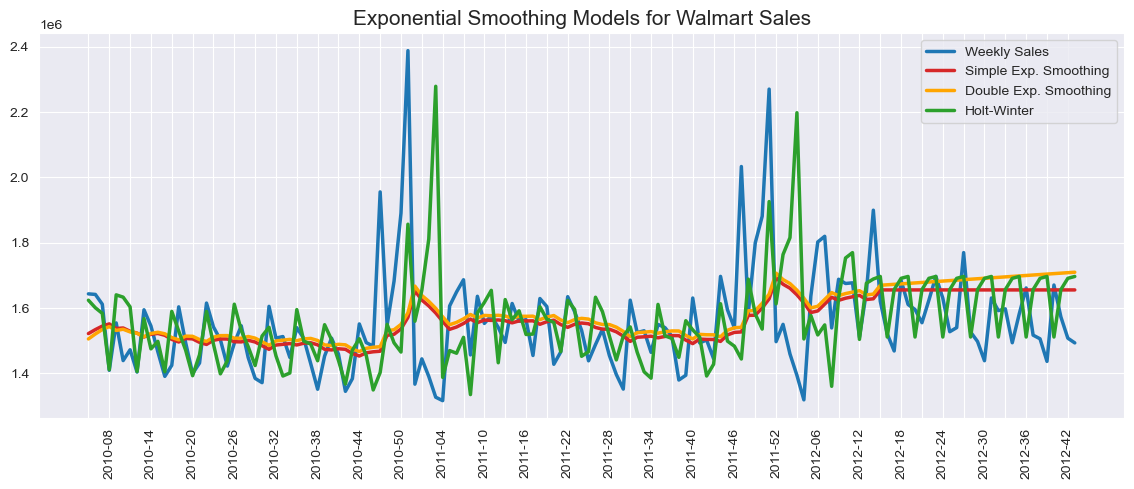

In [87]:
sns.set_style("darkgrid")

fig = plt.figure(figsize=(14, 5))
ax  = plt.subplot(111)

plt.xticks(rotation = 90)
plt.title("Exponential Smoothing Models for Walmart Sales", fontsize = 15)

plt.plot(dff['year_week'],
         dff['Store_Sale'],
         color = 'tab:blue',
         label = 'Weekly Sales',
     linewidth = 2.5
         )

plt.setp(ax.get_xticklabels()[::2], visible=False)


# simple smoothing
x = pd.Series(index = dff['year_week'])
x.iloc[:len(Exp_Smooth.fittedvalues)] = Exp_Smooth.fittedvalues
x.iloc[len(Exp_Smooth.fittedvalues):] = forecast['Simple_exp_smooth'].values

plt.plot(dff['year_week'],
         x,
         color = 'tab:red',
         label = 'Simple Exp. Smoothing',
     linewidth = 2.5
         )

# double smoothing
x = pd.Series(index = dff['year_week'])
x.iloc[:len(D_Exp_Smooth.fittedvalues)] = D_Exp_Smooth.fittedvalues
x.iloc[len(D_Exp_Smooth.fittedvalues):] = forecast['Double_exp_smooth'].values

plt.plot(dff['year_week'],
         x,
         color = 'orange',
         label = 'Double Exp. Smoothing',
     linewidth = 2.5
         )


# Holt-Winter 
x = pd.Series(index = dff['year_week'])
x.iloc[:len(holt_winter.fittedvalues)] = holt_winter.fittedvalues
x.iloc[len(holt_winter.fittedvalues):] = forecast['Triple_exp_smooth'].values


plt.plot(dff['year_week'],
        x,
         color = 'tab:green',
         label = 'Holt-Winter',
     linewidth = 2.5
         )

plt.xticks(df.year_week.unique()[::3])

plt.legend()
plt.show()

### Time Series Models  <a id="2.3.5"></a>

I first take the `log` of the sale series. The modeling and forecasting will use the log series. 

In [101]:
# pd.options.mode.chained_assignment = None  # default='warn'
dff_train['lsale'] = np.log(dff_train['Store_Sale'])

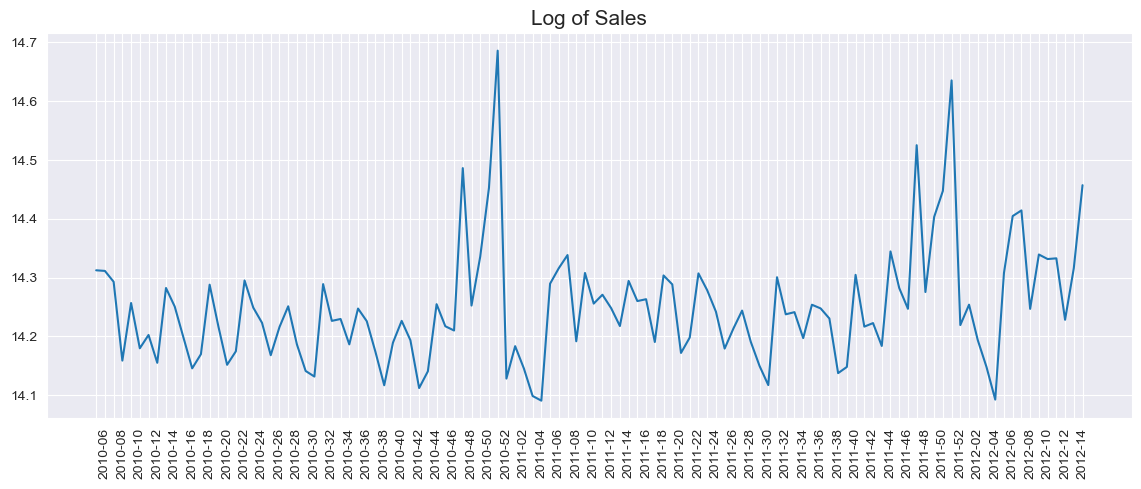

In [41]:
fig = plt.figure(figsize=(14, 5))
ax  = plt.subplot(111)

plt.xticks(rotation = 90)
plt.title("Log of Sales", fontsize = 15)

ax.plot(dff_train['year_week'],
         dff_train['lsale'],
         color = 'tab:blue',
         label = 'Weekly Sales'
         )

plt.setp(ax.get_xticklabels()[::2], visible=False)

plt.show()

I will start by fitting an AR(1) model to the data.

In [89]:
model_ar1 = ARIMA(dff_train.lsale, order = (1, 0, 0))

In [66]:
res_ar1 = model_ar1.fit()
print(res_ar1.summary())

                               SARIMAX Results                                
Dep. Variable:                  lsale   No. Observations:                  114
Model:                 ARIMA(1, 0, 0)   Log Likelihood                 107.644
Date:                Sun, 10 Sep 2023   AIC                           -209.288
Time:                        14:45:12   BIC                           -201.079
Sample:                    02-05-2010   HQIC                          -205.957
                         - 04-06-2012                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         14.2504      0.017    835.069      0.000      14.217      14.284
ar.L1          0.3421      0.056      6.154      0.000       0.233       0.451
sigma2         0.0088      0.001      9.921      0.0

This leads to some interesting results:
1. the AR(1) coefficient is positive and significant.
2. there is strong evidence of non-normality of errors (JB)
3. there is strong evidence of Heteroskedasticity.
4. controlling for the volatility of error terms in the equation (sigma2) is significantly important.

Since this is not my final model, I don't further analyze them. Instead, I am going to add seasonal features and trends to the equation just to get a better sense of the data. I only ploy the residuals and finish analyzing AR(1).

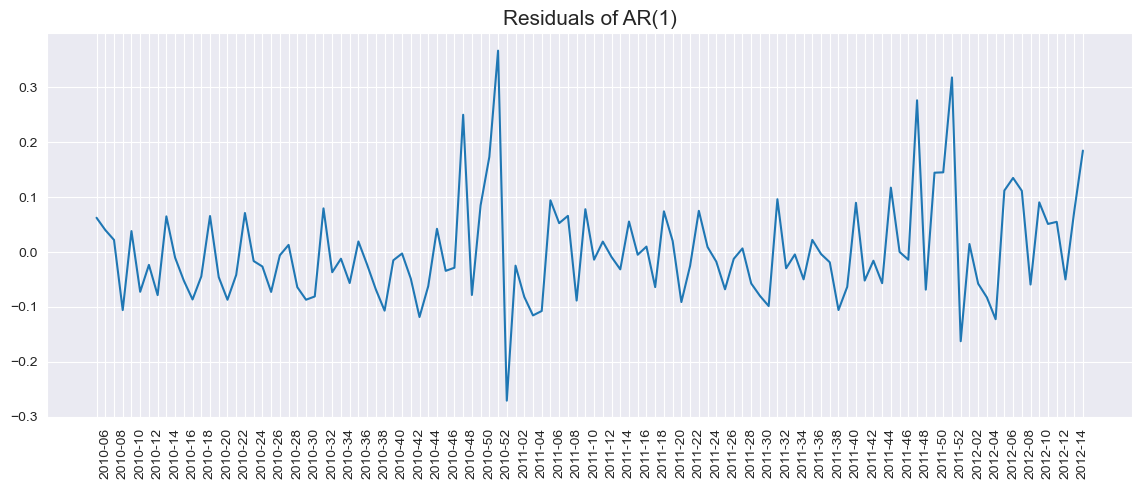

In [45]:
sns.set_style("darkgrid")
fig = plt.figure(figsize=(14, 5))
ax  = plt.subplot(111)

plt.xticks(rotation = 90)
plt.title("Residuals of AR(1)", fontsize = 15)

ax.plot(dff_train['year_week'],
        res_ar1.resid,
        color = 'tab:blue'
         )

plt.setp(ax.get_xticklabels()[::2], visible=False)

plt.show()




This next model only adds a seasonal component to the model. Given our visualization before, I add one AR lag with the cycle duration being equal to four. This should take care of monthly cycles.

In [46]:
model_sar1 = ARIMA(dff_train.lsale,
                  order          = (1, 0, 0),
                  seasonal_order = (1, 0 , 0, 4),
                  trend          = None
                     )

res_sar1 = model_sar1.fit()
print(res_sar1.summary())

                                    SARIMAX Results                                    
Dep. Variable:                           lsale   No. Observations:                  114
Model:             ARIMA(1, 0, 0)x(1, 0, 0, 4)   Log Likelihood                 112.954
Date:                         Fri, 08 Sep 2023   AIC                           -217.909
Time:                                 16:24:35   BIC                           -206.964
Sample:                             02-05-2010   HQIC                          -213.467
                                  - 04-06-2012                                         
Covariance Type:                           opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         14.2528      0.024    582.620      0.000      14.205      14.301
ar.L1          0.4127      0.056      7.371      0.000     

It is evident that the second model SAR(1) outperforms a simple AR(1). However, to test this statisically, I use the `LLR` test as follows:

**Log-Likelihood Ratio**


In [67]:
def LLR_Test(mod_1, mod_2, df):
    ll1   = mod_1.fit().llf
    ll2   = mod_2.fit().llf
    LLR   = (2*(ll2-ll1))
    P_val = chi2.sf(LLR, df).round(4)
    return LLR, P_val

In [52]:
print('Comparing AR(1) and SAR(1) ')
print("==========================================================")
print('Log-Likelihood Ratio Test Statistics: ', LLR_Test(model_ar1, model_sar1, df = 1)[0].round(3))
print('Log-Likelihood Ratio Test P-Value   :  ', LLR_Test(model_ar1, model_sar1, df = 1)[1].round(3))

Comparing AR(1) and SAR(1) 
Log-Likelihood Ratio Test Statistics:  10.621
Log-Likelihood Ratio Test P-Value   :   0.001


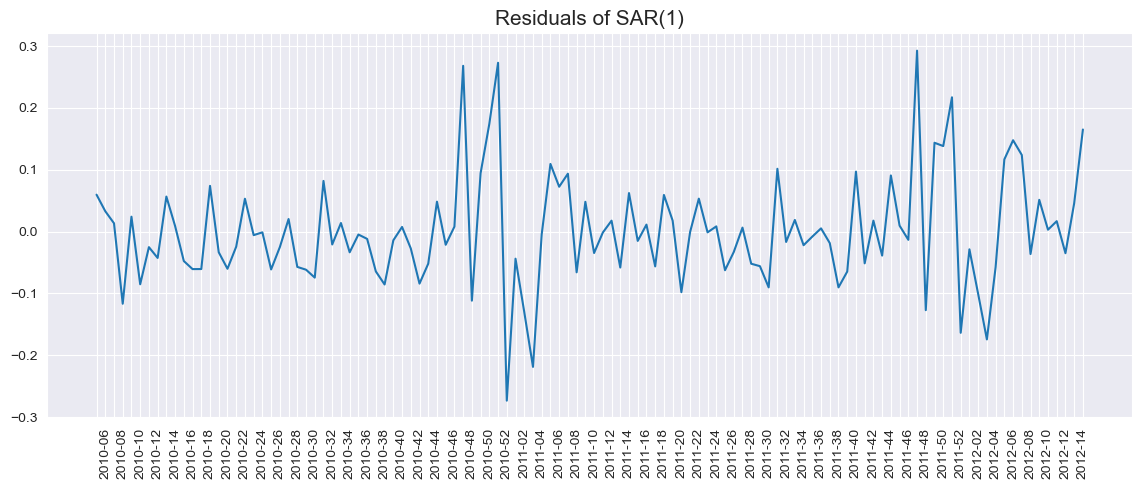

In [229]:
fig = plt.figure(figsize=(14, 5))
ax  = plt.subplot(111)

plt.xticks(rotation = 90)
plt.title("Residuals of SAR(1)", fontsize = 15)

ax.plot(dff_train['year_week'],
        res_sar1.resid,
        color = 'tab:blue'
         )

plt.setp(ax.get_xticklabels()[::2], visible=False)

plt.show()



Though the SAR(1) model performs better than the AR(1) model, a visual analysis of the residual clearly shows that there are still some valuable information left unextracted.

In [53]:
print('Summary Statistics of the residuals of SAR(1) Model:')
print("======================================================")
print('Mean of residuals:\t', round(res_sar1.resid.mean(), 4))
print('STD of residuals :\t ', round(res_sar1.resid.std(), 4) )
print('ADF P-value      :\t ', round(sts.adfuller(res_sar1.resid.dropna())[1],4))
print('')

Summary Statistics of the residuals of SAR(1) Model:
Mean of residuals:	 -0.0004
STD of residuals :	  0.0901
ADF P-value      :	  0.0



I use the `PACF` function to guide us for a better AR lag. It seems that the `1st`, `4th` and `5th` lag are important. In addition to that, there is a high correlation with the last year sale. In order to include that in the model, I am going to define an annual cycle for `seasonal order` -*i.e., 52 weeks*, and include one AR lag for the seasonal component.

**Note:** I know we don't have enough information to include the `52nd` lag but I am going to push it!

Similarly, the `ACF` function suggests that we should include the `1st`, `4th` and `52nd` MA lag. Therefore, I define AR and MA orders accordingly: 
* p = (1, 0, 0, 1, 1)
* q = (1, 0, 0, 1)

However, after a few try and erros, I made a two changes in the model:
* drop the first MA lag
* drop the 52nd MA lag

This was done based on the significance of the variables as well as the information criteria. 

The final version is as follows:

In [68]:
model_sarima = ARIMA(dff_train.lsale,
                  order          = ([1, 4, 5], 0, [1, 4]),
                  seasonal_order = (1, 0 , 0, 52),
                  trend          = None
                     )

res_sarima = model_sarima.fit(method_kwargs={'maxiter':300})
print(res_sarima.summary())

                                           SARIMAX Results                                            
Dep. Variable:                                          lsale   No. Observations:                  114
Model:             ARIMA([1, 4, 5], 0, [1, 4])x(1, 0, [], 52)   Log Likelihood                 158.678
Date:                                        Sun, 10 Sep 2023   AIC                           -301.355
Time:                                                14:45:38   BIC                           -279.466
Sample:                                            02-05-2010   HQIC                          -292.471
                                                 - 04-06-2012                                         
Covariance Type:                                          opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         14.2

In [232]:
print('Summary Statistics of the residuals of SARIMA(p,0,q) Model:')
print('-----------------------------------------------------------')
print('Mean of residuals:\t', round(res_sarima.resid.mean(), 4))
print('STD of residuals :\t', round(res_sarima.resid.std(), 4) )
print('ADF P-value      :\t', round(sts.adfuller(res_sarima.resid.dropna())[1],4))
print('')


Summary Statistics of the residuals of SARIMA(p,0,q) Model:
-----------------------------------------------------------
Mean of residuals:	 0.0018
STD of residuals :	 0.0704
ADF P-value      :	 0.0



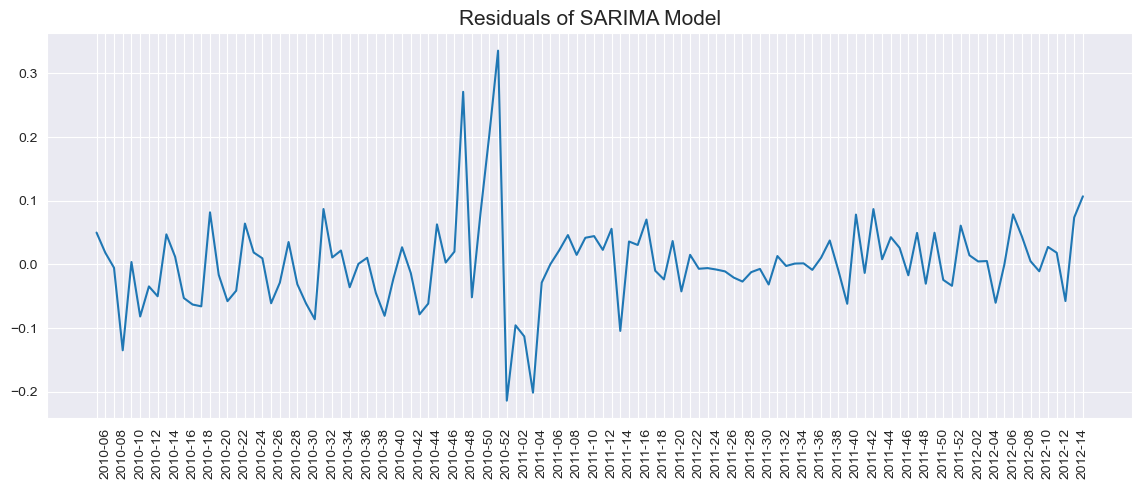

In [233]:
fig = plt.figure(figsize=(14, 5))
ax  = plt.subplot(111)
 
plt.xticks(rotation = 90)
plt.title("Residuals of SARIMA Model", fontsize = 15)

ax.plot(dff_train['year_week'],
        res_sarima.resid,
        color = 'tab:blue'
         )

plt.setp(ax.get_xticklabels()[::2], visible=False)

plt.show()

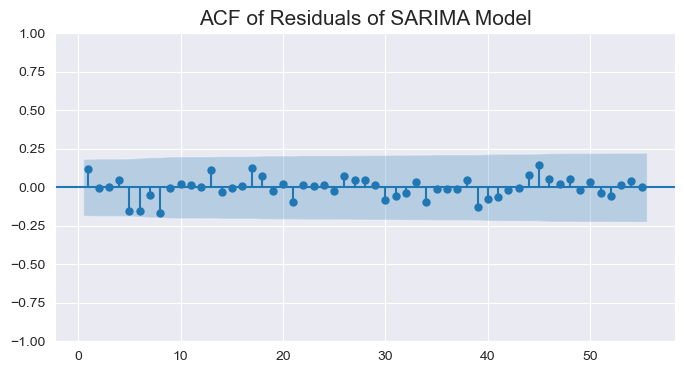

In [234]:
pylab.rcParams['figure.figsize'] = (8, 4)
sgt.plot_acf(res_sarima.resid, lags = 55, zero = False)
plt.title("ACF of Residuals of SARIMA Model", size = 15)
plt.show()

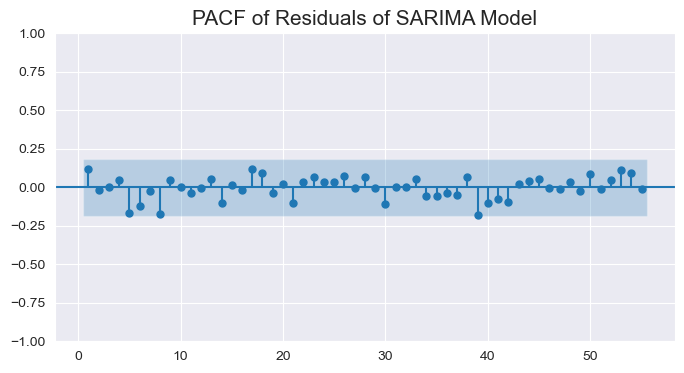

In [235]:
pylab.rcParams['figure.figsize'] = (8, 4)
sgt.plot_pacf(res_sarima.resid, lags = 55, zero = False, method='ywm')
plt.title("PACF of Residuals of SARIMA Model", size = 15)
plt.show()

Lastly, I plot the diagnostics of this model as it seems to be our best fit so far!

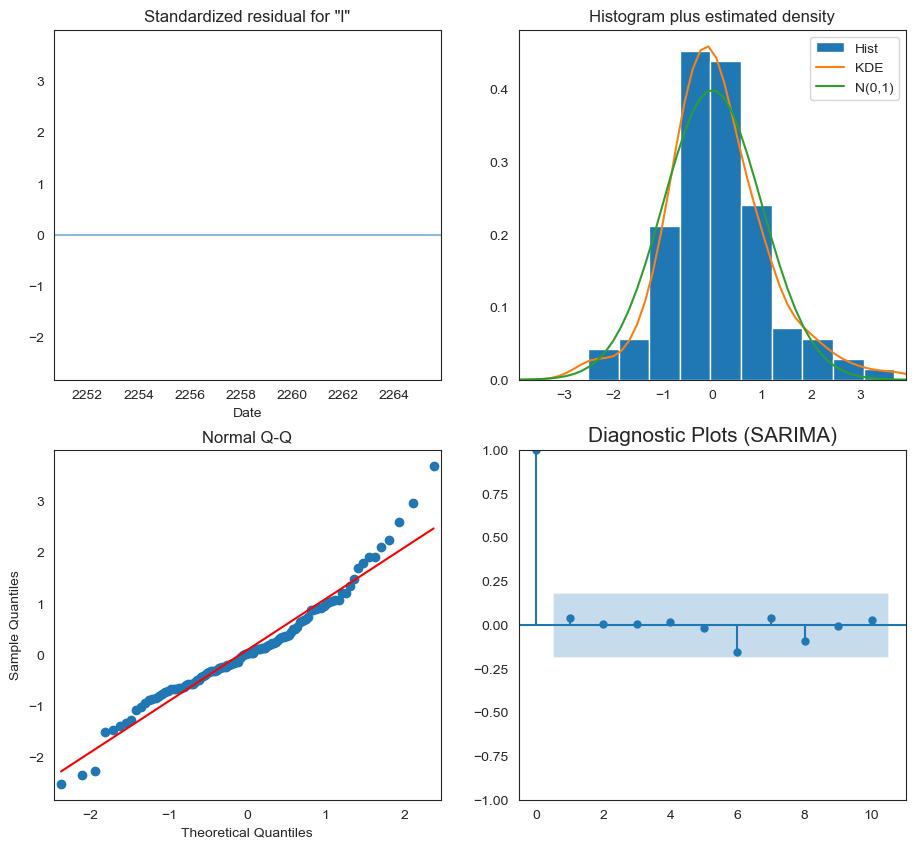

In [200]:

res_sarima.plot_diagnostics(figsize=(11, 10))
plt.show()

**Auto-ARIMA**


In [237]:
auto_1 = auto_arima(dff_train.lsale)
print(auto_1.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  114
Model:               SARIMAX(5, 1, 1)   Log Likelihood                 114.629
Date:                Thu, 07 Sep 2023   AIC                           -215.257
Time:                        18:13:03   BIC                           -196.166
Sample:                    02-05-2010   HQIC                          -207.510
                         - 04-06-2012                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3371      0.107      3.143      0.002       0.127       0.547
ar.L2         -0.0245      0.100     -0.245      0.807      -0.221       0.172
ar.L3         -0.0675      0.090     -0.752      0.4

Then, I use relevent arguments to make the search more customized; only *NO* `exogenous` arguments so far!

In [238]:
auto_arima_model = auto_arima(dff_train.lsale,
                              exogenous = [],
                              max_order = None, # max p+q
                              start_p   = 1, 
                              start_q   = 0,
                              test      = 'adf',
                              max_p     = 6,
                              max_q     = 4,
                              max_d     = 2,
                              m         = 52, # length of the season
                              seasonal  = True,
                              max_P     = 1,
                              max_Q     = 1,
                              max_D     = 1,
                              maxiter   = 400,
                              stepwise  = False, # this makes the code much slower but goes through all the model combination!
                              n_jobs    = -1,    # run as many models as you can at the same time!
                              error_action      = 'ignore',  
                              suppress_warnings = True
                             )

                        
print(auto_arima_model.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  114
Model:             SARIMAX(0, 0, 4)x(1, 0, [], 52)   Log Likelihood                 155.275
Date:                             Thu, 07 Sep 2023   AIC                           -296.550
Time:                                     18:16:52   BIC                           -277.396
Sample:                                 02-05-2010   HQIC                          -288.776
                                      - 04-06-2012                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.9714      0.437      4.511      0.000       1.115       2.828
ma.L1          0.3753      

The best model is: `SARIMA(0, 0, 4)x(1, 0, [], 52)`!

**SARIMAX Model**

I added all the features to the best `SARIMA` model that we had found. Then, after droping the insignificant variables and manually trying some iteration, here is the best `SARIMAX` model that I could find:

In [242]:
X_var = dff_train.loc[:,[ 'CPI', 'week47', 'week49', 'week50', 'week51']]

sarimax_model   = SARIMAX(endog          = dff_train.lsale, 
                          exog           = X_var, 
                          order          = ([1, 4], 0, [1]),
                          seasonal_order = (1, 0 , 0, 52),
                          trend          = None,
                          method_kwargs  = {'maxiter':5000})
res_sarimax = sarimax_model.fit()
print(res_sarimax.summary())

                                        SARIMAX Results                                         
Dep. Variable:                                    lsale   No. Observations:                  114
Model:             SARIMAX([1, 4], 0, 1)x(1, 0, [], 52)   Log Likelihood                 170.422
Date:                                  Thu, 07 Sep 2023   AIC                           -320.844
Time:                                          18:22:34   BIC                           -293.482
Sample:                                      02-05-2010   HQIC                          -309.739
                                           - 04-06-2012                                         
Covariance Type:                                    opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
CPI            0.0636      0.006     11.284      0.000       0.053

In [243]:
auto_sarimax_model = auto_arima(dff_train.lsale,
                              exogenous = X_var,
                              max_order = None, # max p+q
                              start_p   = 1, 
                              start_q   = 0,
                              test      = 'adf',
                              max_p     = 6,
                              max_q     = 4,
                              max_d     = 2,
                              m         = 52, # length of the season
                              seasonal  = True,
                              max_P     = 1,
                              max_Q     = 1,
                              max_D     = 1,
                              maxiter   = 400,
                              stepwise  = False, # this makes the code much slower but goes through all the model combination!
                              n_jobs    = -1,    # run as many models as you can at the same time!
                              error_action      = 'ignore',  
                              suppress_warnings = True
                             )


                        
print(auto_sarimax_model.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  114
Model:             SARIMAX(0, 0, 4)x(1, 0, [], 52)   Log Likelihood                 155.275
Date:                             Thu, 07 Sep 2023   AIC                           -296.550
Time:                                     18:26:05   BIC                           -277.396
Sample:                                 02-05-2010   HQIC                          -288.776
                                      - 04-06-2012                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.9714      0.437      4.511      0.000       1.115       2.828
ma.L1          0.3753      

Finally, the best `SARIMAX` model that the machine can charactrize on its own is the one above. I plot some diagnostic figures and proceed to storing forecasts. 

In [244]:
print('Summary Statistics of the residuals of SARIMAX(p,0,q)x(P,0,Q,m) Model:')
print('----------------------------------------------------------------------')
print('Mean of residuals:\t', round(res_sarimax.resid.mean(), 4))
print('STD of residuals :\t', round(res_sarimax.resid.std(), 4) )
print('ADF P-value      :\t', round(sts.adfuller(res_sarimax.resid.dropna())[1],4))
print('')
print('This is very close to a white noise!')

Summary Statistics of the residuals of SARIMAX(p,0,q)x(P,0,Q,m) Model:
----------------------------------------------------------------------
Mean of residuals:	 -0.0006
STD of residuals :	 0.0982
ADF P-value      :	 0.0

This is very close to a white noise!


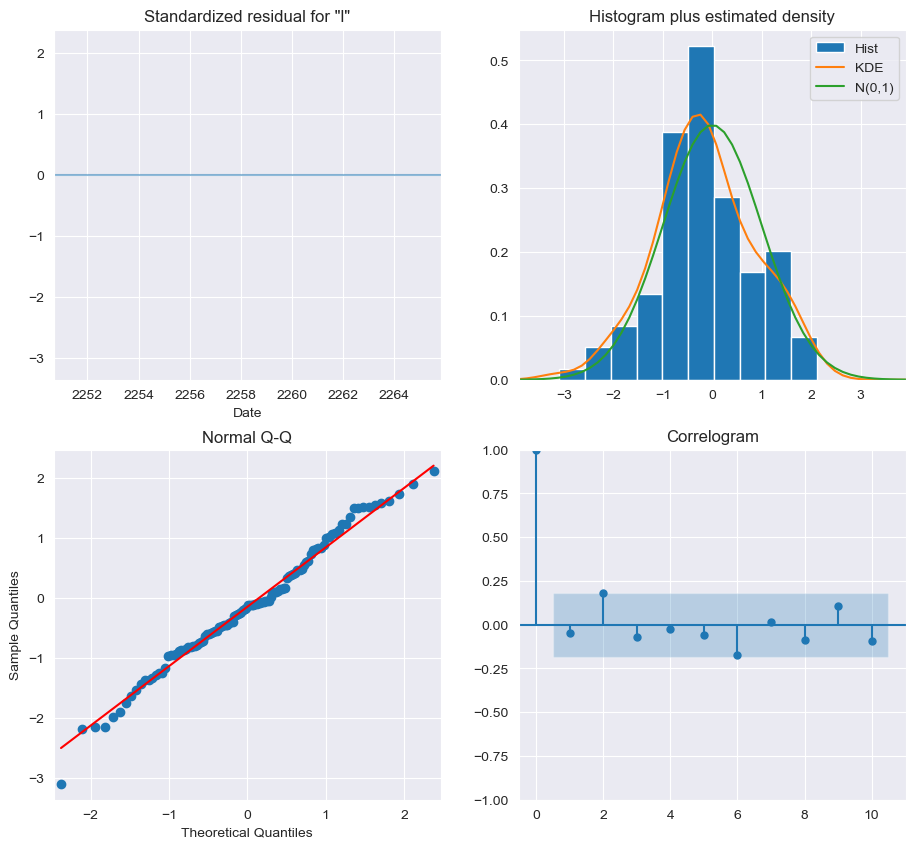

In [247]:
res_sarimax.plot_diagnostics(figsize=(11,10))
plt.show()

Based on the analysis above, I select the following models for forecasting:
1. model_1: SARIMA  with (p,d,q) = (1, 0, 0)              and (P,D,Q,m) = (1, 0, 0, 4) 
2. model_2: SARIMA  with (p,d,q) = ((1, 4, 5), 0, (1, 4)) and (P,D,Q,m) = (1, 0, 0, 52) 
3. model_3: SARIMAX with (p,d,q) = (0, 0, 4)              and (P,D,Q,m) = (1, 0, 0, 52)
4. model_4: SARIMAX with (p,d,q) = ((1, 4), 0, 1)         and (P,D,Q,m) = (1, 0, 0, 52) 

In [102]:
X_var = dff_train.loc[:,[ 'CPI', 'week47', 'week49', 'week50', 'week51']]

AR_1 = ARIMA(dff_train.lsale,
                order          = (1, 0, 0),
                seasonal_order = (1, 0 , 0, 4),
                trend          = None)

SARIMA_1 = ARIMA(dff_train.lsale,
                order          = (0, 0, 4),
                seasonal_order = (1, 0 , 0, 52),
                trend          = None)

SARIMA_2 = ARIMA(dff_train.lsale,
                order          = ([1, 4, 5], 0, [1, 4]),
                seasonal_order = (1, 0 , 0, 52),
                trend          = None)


SARIMAX   = SARIMAX(endog          = dff_train.lsale, 
                    exog           = X_var, 
                    order          = ([1, 4], 0, [1]),
                    seasonal_order = (1, 0 , 0, 52),
                    trend          = None,
                    method_kwargs  = {'maxiter':500})



res_ar_1     = AR_1.fit()
res_sarima_1 = SARIMA_1.fit(method_kwargs={'maxiter':300})
res_sarima_2 = SARIMA_2.fit(method_kwargs={'maxiter':400})
res_sarimax  = SARIMAX.fit()


In [252]:
print(res_sarimax.summary())

                                        SARIMAX Results                                         
Dep. Variable:                                    lsale   No. Observations:                  114
Model:             SARIMAX([1, 4], 0, 1)x(1, 0, [], 52)   Log Likelihood                 170.422
Date:                                  Thu, 07 Sep 2023   AIC                           -320.844
Time:                                          18:31:24   BIC                           -293.482
Sample:                                      02-05-2010   HQIC                          -309.739
                                           - 04-06-2012                                         
Covariance Type:                                    opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
CPI            0.0636      0.006     11.284      0.000       0.053

In [103]:
# get the forecast period
start_forecast = forecast.index[0]
end_forecast   = forecast.index[-1]

In [104]:
forecast['AR_1'] = np.exp(res_ar_1.predict(start = start_forecast,
                                           end   = end_forecast,
                                 return_conf_int = True))

forecast['SARIMA-1'] = np.exp(res_sarima_1.predict(start = start_forecast,
                                                   end   = end_forecast,
                                         return_conf_int = True))

forecast['SARIMA'] = np.exp(res_sarima_2.predict(start = start_forecast,
                                                   end   = end_forecast,
                                         return_conf_int = True))


X_forecast = dff_test.loc[:,[ 'CPI', 'week47', 'week49', 'week50', 'week51']]

forecast['SARIMAX'] = np.exp(res_sarimax.predict(start = start_forecast,
                                                 end   = end_forecast,
                                                 exog  = X_forecast,
                                       return_conf_int = True))



## Comparing Forecasts <a id="2.4"></a>




### Accuracy Measures <a id="2.4.1"></a>

In [117]:
forecast_res = pd.DataFrame(index = forecast.keys().values[1:])

In [118]:

for i in range(len(forecast.keys())-1):
    forecast_res.loc[forecast_res.index[i],'RMSE']  = math.sqrt(mse(forecast.Sales,
                                                                                  forecast[forecast.keys().values[i+1]]))

    forecast_res.loc[forecast_res.index[i],'Normalized RMSE'] = forecast_res.loc[forecast_res.index[i],'RMSE']/forecast.Sales.mean()

    forecast_res.loc[forecast_res.index[i],'MAE']   = mae(forecast.Sales, forecast[forecast.keys().values[i+1]])
    forecast_res.loc[forecast_res.index[i],'MAPE']  = mape(forecast.Sales, forecast[forecast.keys().values[i+1]])
    
sorted_rmse = forecast_res.sort_values(by=['RMSE'], ascending=True)
sorted_rmse

RMSE  Normalized RMSE            MAE      MAPE
SARIMA              60497.813757         0.038493   47213.560131  0.029657
Weighted_R_avg      67416.345257         0.042895   49986.114741  0.030994
AR_1                79535.495594         0.050606   64383.660827  0.040647
SARIMA-1            81119.301171         0.051613   63910.917703  0.040143
Naive               84886.969167         0.054010   67537.609655  0.042488
Rolling_avg         91984.298893         0.058526   78187.617672  0.050127
Simple_exp_smooth  115823.401861         0.073694   98240.597709  0.064347
Triple_exp_smooth  135897.738232         0.086467  117173.834473  0.076201
Double_exp_smooth  144728.878059         0.092086  125785.640616  0.082368
SARIMAX            164616.325485         0.104739  154069.686862  0.099336
White Noise        168205.924328         0.107023  140061.204634  0.089338

### Visual Comparison <a id="2.4.2"></a>

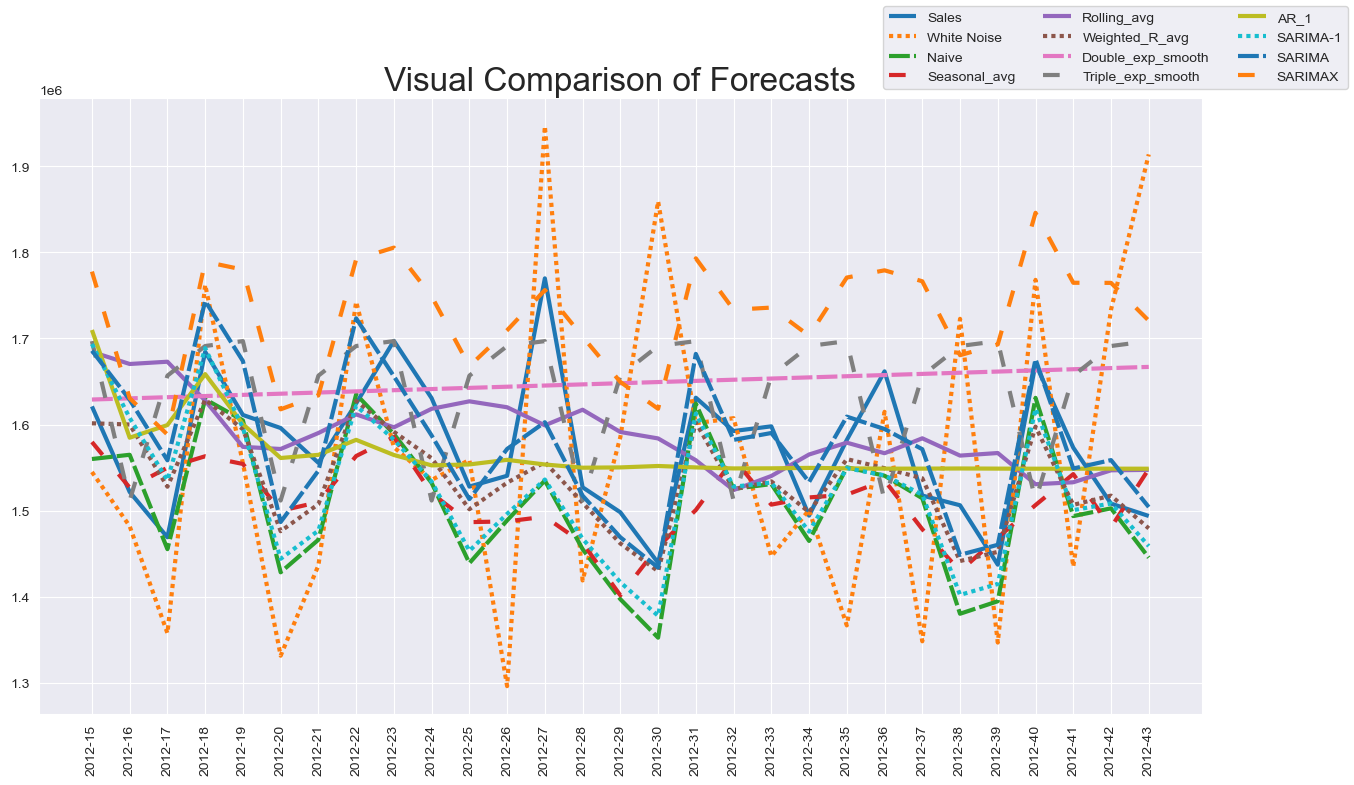

In [158]:
# color_map = iter(plt.cm.rainbow(np.linspace(0, 1, len(forecast.keys()))))

linestyle_tuple = [(0, ()),
                   (0, (1, 1)),
                   (0, (5, 1)),
                   (0, (4, 6))]

sns.set_style('darkgrid')

fig = plt.figure(figsize=(15, 8))
ax  = plt.subplot(111)

plt.xticks(rotation = 90)
plt.title("Visual Comparison of Forecasts", fontsize = 24)


    
for i in range(len(forecast.keys())):
    ax.plot(dff_test['year_week'],
            forecast[forecast.keys().values[i]],
#             color = next(color_map),
            label = forecast.keys().values[i],
        linestyle = linestyle_tuple[np.mod(i,len(linestyle_tuple))],
        linewidth = 3
             )


fig.legend(ncol=3)
plt.show()

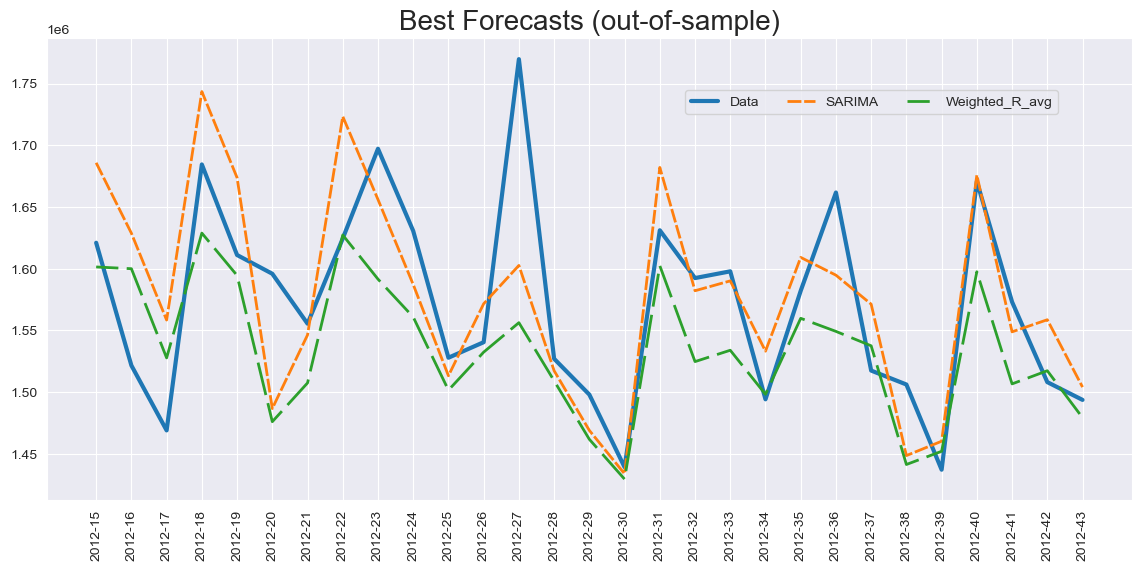

In [120]:
sns.set_style('darkgrid')

linestyle_tuple = [(0, (5, 1)), (4, (12, 3)), (0, (3, 5, 1, 5))]


fig = plt.figure(figsize=(14, 6))
ax  = plt.subplot(111)

plt.xticks(rotation = 90)
plt.title("Best Forecasts (out-of-sample)", fontsize = 20)


ax.plot(dff_test['year_week'],
        forecast['Sales'],
            label = 'Data',
        linewidth = 3)

for i in range(2):
    ax.plot(dff_test['year_week'],
            forecast[sorted_rmse.index[i]],
            label = sorted_rmse.index[i],
        linestyle = linestyle_tuple[np.mod(i,len(linestyle_tuple))],
        linewidth = 2)


fig.legend(loc = (0.6, 0.8), ncol = 3)
plt.show()

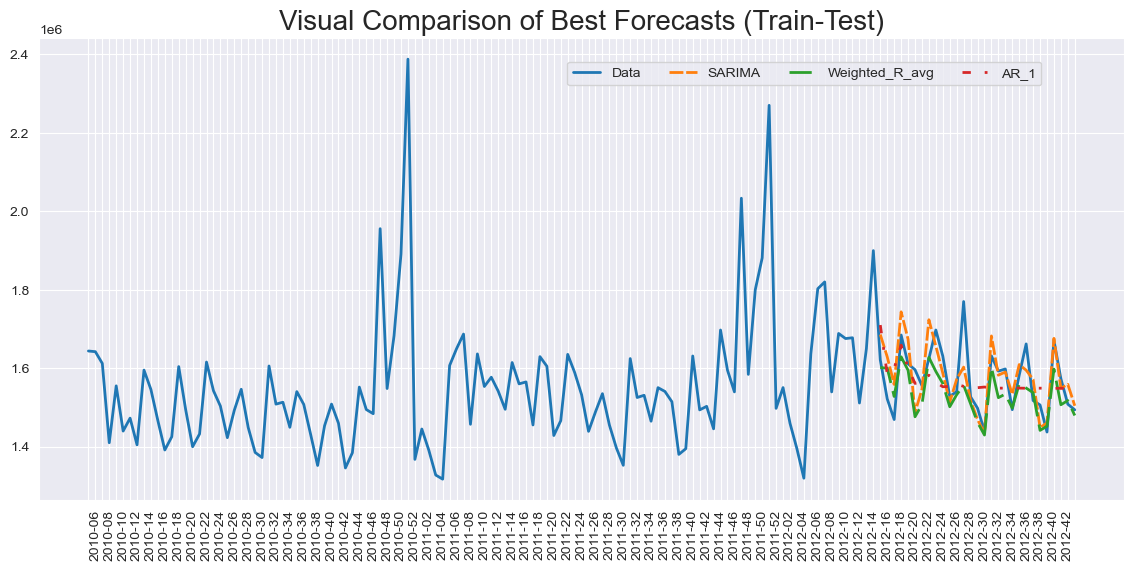

In [160]:

linestyle_tuple = [(0, (5, 1)), (4, (12, 3)), (0, (3, 5, 1, 5))]


fig = plt.figure(figsize=(14, 6))
ax  = plt.subplot(111)

plt.xticks(rotation = 90)
plt.title("Visual Comparison of Best Forecasts (Train-Test)", fontsize = 20)

ax.plot(dff['year_week'],
        dff['Store_Sale'],
        label = 'Data',
        linewidth = 2)


for i in range(3):
    ax.plot(dff_test['year_week'],
            forecast[sorted_rmse.index[i]],
            label = sorted_rmse.index[i],
        linestyle = linestyle_tuple[np.mod(i,len(linestyle_tuple))],
        linewidth = 2)
plt.setp(ax.get_xticklabels()[::2], visible=False)


fig.legend(loc = (0.5, 0.85), ncol = 4)
plt.show()

The above analysis shows that the `SARIMA` model provides the best out-of-sample forecasts with the lowest `RMSE`. Here is the graph: 

In [162]:
result = res_sarima_2.get_forecast(len(forecast))

forecast['Lower'] = np.exp(result.conf_int(alpha=0.1).values[:,0])
forecast['Upper'] = np.exp(result.conf_int(alpha=0.1).values[:,1])

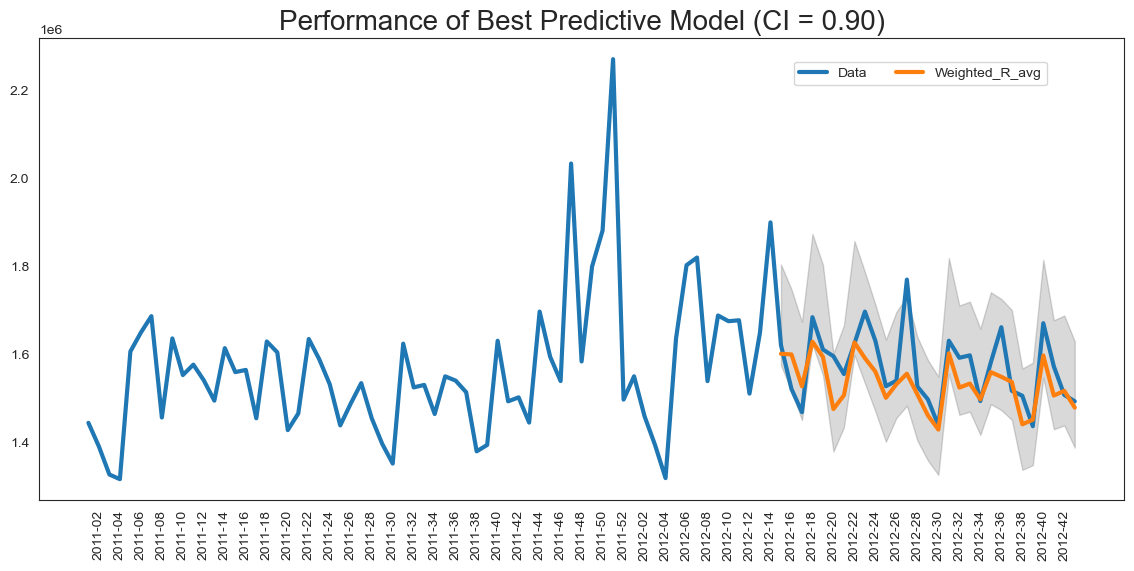

In [181]:
sns.set_style('white')
fig = plt.figure(figsize=(14, 6))
ax  = plt.subplot(111)

plt.xticks(rotation = 90)
plt.title("Performance of Best Predictive Model (CI = 0.90)", fontsize = 20)
ax.grid(False)

ax.plot(dff['year_week']["2011":],
        dff['Store_Sale']["2011":],
        label     = 'Data',
        linewidth = 3)



ax.plot(dff_test['year_week'],
        forecast[sorted_rmse.index[1]],
        label     = sorted_rmse.index[1],
        linewidth = 3)
    

plt.fill_between(dff_test['year_week'], 
                    forecast['Lower'], 
                    forecast['Upper'], 
                    color = "k",
                    alpha = .15)

plt.setp(ax.get_xticklabels()[::2], visible=False)


fig.legend(loc = (0.70, 0.85), ncol = 3)
plt.show()

## Concluding Remarks <a id="2.5"></a>
To conclude this report, I'd like to briefly discuss two points:

### SARIMAX Model
As is evident in the foloowing graph, the SARIMAX model provides an excellent fit for the train set. Then, why is that its out-of-sample forecasts are *NOT* among top three models?

The answer, in my opinion, lies in the role of holidays in our analysis. In my split, there are no holiday weeks in the test set. This is while holiday dummies are the most advantagous aspect of the SARIMAX model over the SARIMA. Since there are no holiday weeks in the test set, the SARIMAX model becomes a classic example of overfitting where the model performs extraordinarily well in the train set but fails to provide accurate out-of-sample forecasts. 

A visual comparison between the actual series and the forecasts suggest that the SARIMAX model gets the fluctuation of the data very well -similar to the SARIMA model. However, there appears to be a bias in the level, which I believe results from the holiday weeks. This leads to a `biased intercept` that performs well in the train set but over-predicts the test set. 


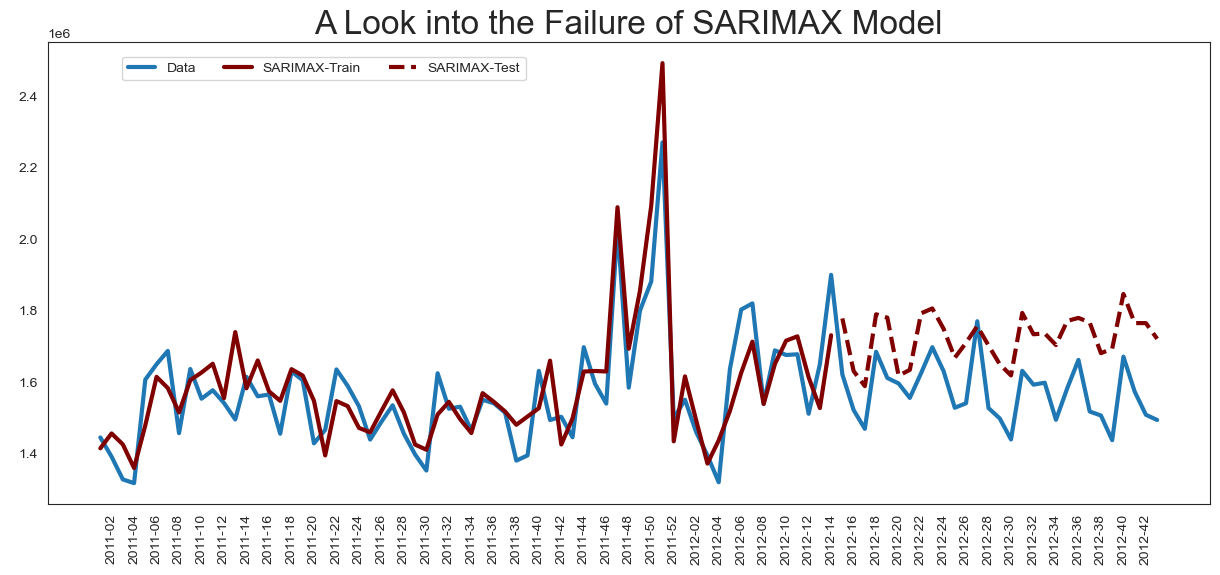

In [188]:

sns.set_style('white')

fig = plt.figure(figsize=(15, 6))
ax  = plt.subplot(111)
ax.grid(False)
plt.xticks(rotation = 90)
plt.title("A Look into the Failure of SARIMAX Model", fontsize = 24)


ax.plot(dff['year_week']["2011":],
        dff['Store_Sale']["2011":],
            label = 'Data',
            color = 'tab:blue',
        linewidth = 3)

fc_in_samp = np.exp(res_sarimax.predict(start = dff_train.index[0],
                                        end   = dff_train.index[-1],
                                        exog  = X_var,
                                       return_conf_int = True))

ax.plot(dff_train['year_week']["2011":],
        fc_in_samp["2011":],
            label = 'SARIMAX-Train',
            color = 'maroon',

        linewidth = 3 )


ax.plot(dff_test['year_week'],
        forecast.SARIMAX,
            label = 'SARIMAX-Test',
            color = 'maroon',
        linestyle = '--',
        linewidth = 3 )

plt.setp(ax.get_xticklabels()[::2], visible=False)
fig.legend(loc = (0.10, 0.86), ncol = 3)
plt.show()

### Approach to Original Data 
Based on my experience with this data, here is my suggestion to forecast the weekly sales of all stores or departments.  Seasonal patterns -specially last year's sales- are powerfull predictors of future sales. The `Naive` forecasts was the fifth best model in my exercise. All we do is to improve that `Naive` forecast with the use of features and time series techniques. 

1. The most important features are the `CPI`, and `IsHoliday` broken to four dummies.
2. Compute the effect of features in the first step, and find the residual series. This series would be `stationary` and easy to forecast with the SARIMA model. 
3. Unless holiday weeks are concerned, incorporating features does not necessairly improve the forecasts.

